# **Reddit Yatırım Topluluklarında Gönderi Etkileşiminin Tahmini ve Manipülasyon Kaynaklı Hype Tespitinin Birleşik Analizi**

# ***⭐  Etkileşim Tahmini Analizleri (Engagement Prediction)***
Etkileşim Tahmini Analizleri, bir sosyal medya gönderisinin paylaşıldıktan sonra ne ölçüde başarılı olacağını öngörmeyi amaçlayan veri odaklı analizlerdir. Bu başarı; gönderinin aldığı beğeni (score), yorum sayısı (num_comments) ve yayılma düzeyi gibi metrikler üzerinden değerlendirilir.

Analizin temel amacı, hangi faktörlerin kullanıcı etkileşimini artırdığını belirlemek ve gelecekte paylaşılacak içerikler için daha etkili stratejiler geliştirmektir.
Bu çalışma kapsamında, bir gönderinin etkileşim performansı aşağıdaki temel parametreler üzerinden incelenmektedir.


🚀 **ÖNCE VERİYİ ALALIM**

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project='odev-482215')

tables = [
    "finance_clean",
    "financialindependence_clean",
    "forex_clean",
    "gme_clean",
    "investing_clean",
    "options_clean",
    "pennystocks_clean",
    "personalfinance_clean",
    "robinhood_clean",
    "robinhoodpennystock_backup_jan27",
    "securityanalysis",
    "stockmarket",
    "stocks",
    "wallstreetbet"
]

dataframes = {}

for table in tables:
    query = f"""
    SELECT *
    FROM `odev-482215.reddit_data.{table}`
    """
    dataframes[table] = client.query(query).to_dataframe()
    print(f"{table} yüklendi → satır sayısı:", len(dataframes[table]))

finance_clean yüklendi → satır sayısı: 780
financialindependence_clean yüklendi → satır sayısı: 1503
forex_clean yüklendi → satır sayısı: 5272
gme_clean yüklendi → satır sayısı: 212686
investing_clean yüklendi → satır sayısı: 6161
options_clean yüklendi → satır sayısı: 15667
pennystocks_clean yüklendi → satır sayısı: 14378
personalfinance_clean yüklendi → satır sayısı: 98329
robinhood_clean yüklendi → satır sayısı: 425
robinhoodpennystock_backup_jan27 yüklendi → satır sayısı: 3521
securityanalysis yüklendi → satır sayısı: 189
stockmarket yüklendi → satır sayısı: 7852
stocks yüklendi → satır sayısı: 25152
wallstreetbet yüklendi → satır sayısı: 33766


#**KEŞİFSEL VERİ ANALİZ AŞAMASI (EDA)**

## ***1-) Zaman Analizi (Created)***

Zaman analizi, gönderinin paylaşıldığı saat ve haftanın günü gibi zamansal değişkenlerin etkileşim üzerindeki etkisini incelemektedir. Kullanıcıların platformda daha aktif olduğu zaman dilimlerinde paylaşılan gönderilerin daha fazla etkileşim alması beklenmektedir. Bu nedenle analiz, “Hangi saatlerde veya hangi günlerde yapılan paylaşımlar daha yüksek score ve yorum sayısına ulaşmaktadır?” sorusuna yanıt arar. Elde edilen bulgular, içerik paylaşım takviminin optimize edilmesi açısından kritik öneme sahiptir.

Google BigQuery üzerinde bulunan Reddit finans subreddit verilerini Python ve Pandas kullanarak çekerek, temizleme ve tek bir veri seti altında birleştirelim. Ayrıca zaman analizi yapılabilmesi için tarih bilgileri saat ve gün bazında ayrıştırılıp ve verileri analiz aşamasına hazır hale getirelim.

In [ ]:
# 1. Yetkilendirme
from google.colab import auth
auth.authenticate_user()

# 2. Kütüphaneler
import pandas as pd
from google.cloud import bigquery

client = bigquery.Client(project='odev-482215')

# 3. Tablolar
tables = [
    "finance_clean",
    "financialindependence_clean",
    "forex_clean",
    "gme_clean",
    "investing_clean",
    "options_clean",
    "pennystocks_clean",
    "personalfinance_clean",
    "robinhood_clean",
    "robinhoodpennystock_backup_jan27",
    "securityanalysis",
    "stockmarket",
    "stocks",
    "wallstreetbet"
]

list_of_dfs = []

# 4. Veri Yükleme + Temizleme
for table in tables:
    try:
        query = f"""
        SELECT *
        FROM `odev-482215.reddit_data.{table}`
        """
        df = client.query(query).to_dataframe()

        # Add subreddit column
        df['subreddit'] = table.replace('_clean', '')

        # ---- VERİ TEMİZLEME ----
        if 'is_video' not in df.columns:
            df['is_video'] = False
        else:
            df['is_video'] = df['is_video'].fillna(False)

        if 'is_self' in df.columns:
            df['is_self'] = df['is_self'].fillna(False)
        else:
            df['is_self'] = False

        list_of_dfs.append(df)
        print(f"✅ {table} yüklendi → {len(df)} satır")

    except Exception as e:
        print(f"❌ HATA - {table} yüklenemedi.\nHata detayı: {e}")

# 5. Birleştirme ve Zaman Analizi
if list_of_dfs:
    all_data = pd.concat(list_of_dfs, ignore_index=True)

    # Tarih işlemleri
    all_data['created'] = pd.to_datetime(all_data['created'], errors='coerce')
    all_data = all_data.dropna(subset=['created'])

    all_data['saat'] = all_data['created'].dt.hour
    all_data['gun'] = all_data['created'].dt.day_name()

    gun_siralamasi = [
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"
    ]
    all_data['gun'] = pd.Categorical(
        all_data['gun'],
        categories=gun_siralamasi,
        ordered=True
    )

    print("\n🚀 İŞLEM TAMAM: 'all_data' oluşturuldu!")
    print(f"Toplam Satır Sayısı: {len(all_data)}")

else:
    print("\n⚠️ HİÇBİR VERİ YÜKLENEMEDİ. Proje ID veya tablo adlarını kontrol et.")

✅ finance_clean yüklendi → 780 satır
✅ financialindependence_clean yüklendi → 1503 satır
✅ forex_clean yüklendi → 5272 satır
✅ gme_clean yüklendi → 212686 satır
✅ investing_clean yüklendi → 6161 satır
✅ options_clean yüklendi → 15667 satır
✅ pennystocks_clean yüklendi → 14378 satır
✅ personalfinance_clean yüklendi → 98329 satır
✅ robinhood_clean yüklendi → 425 satır
✅ robinhoodpennystock_backup_jan27 yüklendi → 3521 satır
✅ securityanalysis yüklendi → 189 satır
✅ stockmarket yüklendi → 7852 satır
✅ stocks yüklendi → 25152 satır
✅ wallstreetbet yüklendi → 33766 satır

🚀 İŞLEM TAMAM: 'all_data' oluşturuldu!
Toplam Satır Sayısı: 425681


### • **Günün Saatlerine Göre Kullanıcı Etkileşimi Analizi**
Bu çalışmada, kullanıcı etkileşiminin günün saatlerine göre nasıl değiştiği incelenmiştir.
Veri setinde yer alan gönderiler, 0–23 saat aralığında gruplandırılmış ve her saat için:
Ortalama yorum sayısı ve Ortalama beğeni (score) hesaplanmıştır.

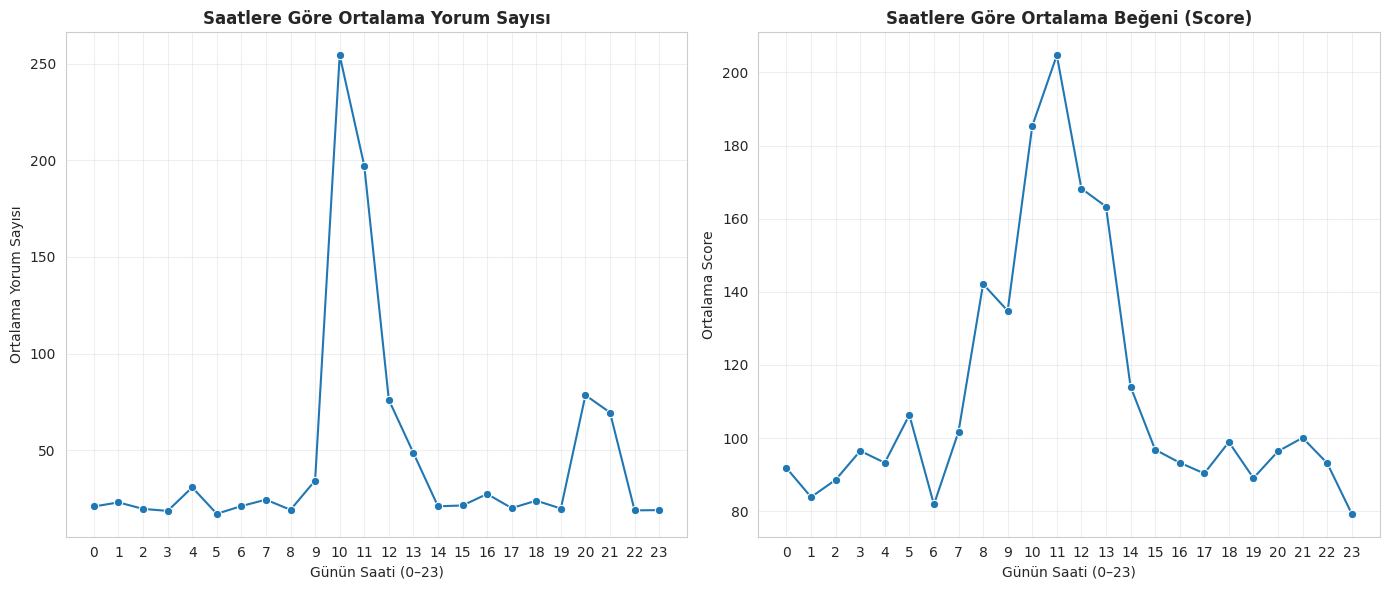

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- GÜVENLİK: Sayısal kolonları temizle ---
for col in ['num_comments', 'score']:
    if col in all_data.columns:
        all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

# Negatif ve NaN değerleri temizle
plot_data = all_data.dropna(subset=['saat', 'num_comments', 'score'])
plot_data = plot_data[(plot_data['num_comments'] >= 0) & (plot_data['score'] >= 0)]

# Grafik ayarları
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# -------------------------------
# SOL GRAFİK: Saate Göre Yorum
# -------------------------------
plt.subplot(1, 2, 1)
sns.lineplot(
    data=plot_data,
    x='saat',
    y='num_comments',
    estimator='mean',
    errorbar=None,
    marker='o'
)
plt.title('Saatlere Göre Ortalama Yorum Sayısı', fontsize=12, fontweight='bold')
plt.xlabel('Günün Saati (0–23)')
plt.ylabel('Ortalama Yorum Sayısı')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)

# -------------------------------
# SAĞ GRAFİK: Saate Göre Score
# -------------------------------
plt.subplot(1, 2, 2)
sns.lineplot(
    data=plot_data,
    x='saat',
    y='score',
    estimator='mean',
    errorbar=None,
    marker='o'
)
plt.title('Saatlere Göre Ortalama Beğeni (Score)', fontsize=12, fontweight='bold')
plt.xlabel('Günün Saati (0–23)')
plt.ylabel('Ortalama Score')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Analiz sonuçlarına göre:

Kullanıcı etkileşimi günün belirli saatlerinde yoğunlaşmaktadır.
Öğle saatleri, hem yorum sayısı hem de beğeni skoru açısından en verimli zaman dilimidir.
İçerik paylaşımı için 10:00–13:00 aralığı, maksimum etkileşim elde etmek açısından en uygun zaman olarak değerlendirilebilir.
Bu sonuçlar, içerik planlaması ve paylaşım stratejilerinin optimize edilmesinde önemli bir rehber niteliğindedir.

### • **Haftanın Günlerine Göre Kullanıcı Etkileşimi Analizi**
Bu analizde, kullanıcı etkileşiminin haftanın günlerine göre dağılımı incelenmiştir.
Veri setinde yer alan gönderiler, haftanın günlerine göre gruplandırılmış ve her gün için: Ortalama yorum sayısı ve Ortalama beğeni (score) hesaplanmıştır.

/tmp/ipython-input-1587082168.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=all_data, x='gun', y='num_comments', estimator='mean', palette='viridis', errorbar=None)
/tmp/ipython-input-1587082168.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=all_data, x='gun', y='score', estimator='mean', palette='magma', errorbar=None)


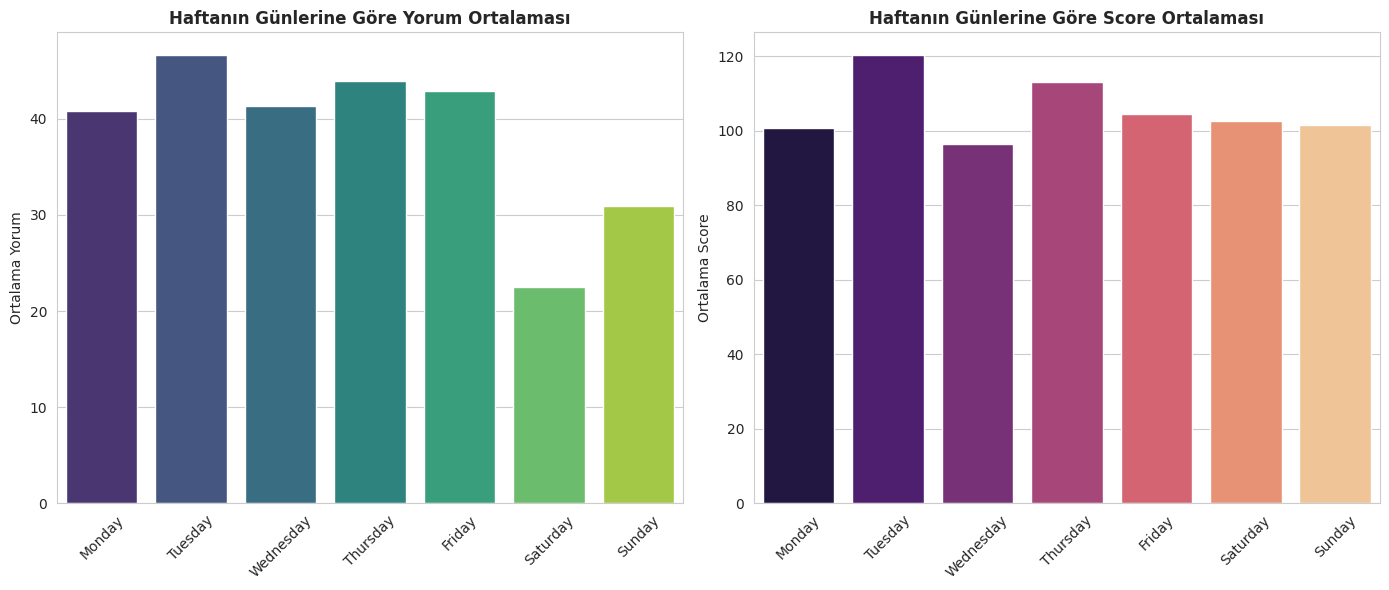

In [ ]:
plt.figure(figsize=(14, 6))

# SOL GRAFİK: Güne Göre Yorum
plt.subplot(1, 2, 1)
sns.barplot(data=all_data, x='gun', y='num_comments', estimator='mean', palette='viridis', errorbar=None)
plt.title('Haftanın Günlerine Göre Yorum Ortalaması', fontsize=12, fontweight='bold')
plt.ylabel('Ortalama Yorum')
plt.xlabel('')
plt.xticks(rotation=45)

# SAĞ GRAFİK: Güne Göre Score
plt.subplot(1, 2, 2)
sns.barplot(data=all_data, x='gun', y='score', estimator='mean', palette='magma', errorbar=None)
plt.title('Haftanın Günlerine Göre Score Ortalaması', fontsize=12, fontweight='bold')
plt.ylabel('Ortalama Score')
plt.xlabel('')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Analiz sonuçları, kullanıcı etkileşiminin hafta içi günlerde daha yoğun olduğunu göstermektedir.
Özellikle Salı ve Perşembe günleri, hem yorum sayısı hem de beğeni skoru açısından en verimli günlerdir.
Bu bulgular doğrultusunda:
İçerik paylaşımlarının hafta içi, özellikle Salı–Perşembe aralığında yapılması,
Maksimum kullanıcı etkileşimi elde edilmesi açısından daha etkili olacaktır.
Bu analiz, içerik paylaşım zamanlamasının optimize edilmesi ve kullanıcı davranışlarının daha iyi anlaşılması için önemli bir referans sunmaktadır.

### • **Gün ve Saat Bazında Beğeni (Score) Yoğunluğu Analizi**
Bu çalışmada, kullanıcı etkileşiminin haftanın günleri ve günün saatleri bazında nasıl değiştiği incelenmiştir.
Analiz öncesinde veri temizleme adımı uygulanmış, score sütunundaki metinsel veya hatalı değerler sayısal forma dönüştürülmüş ve geçersiz değerler analiz dışı bırakılmıştır.
Ardından, pivot tablo oluşturularak: Satırlarda haftanın günleri,
Sütunlarda günün saatleri (0–23),Hücrelerde ise ortalama beğeni (score) değerleri yer alacak şekilde veri yeniden düzenlenmiştir.

Bu yapı kullanılarak ısı haritası (heatmap) oluşturulmuş ve renk yoğunlukları aracılığıyla beğeni skorlarının gün–saat bazındaki dağılımı görsel olarak analiz edilmiştir.

/tmp/ipython-input-2095964157.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = all_data.pivot_table(index='gun', columns='saat', values='score', aggfunc='mean')


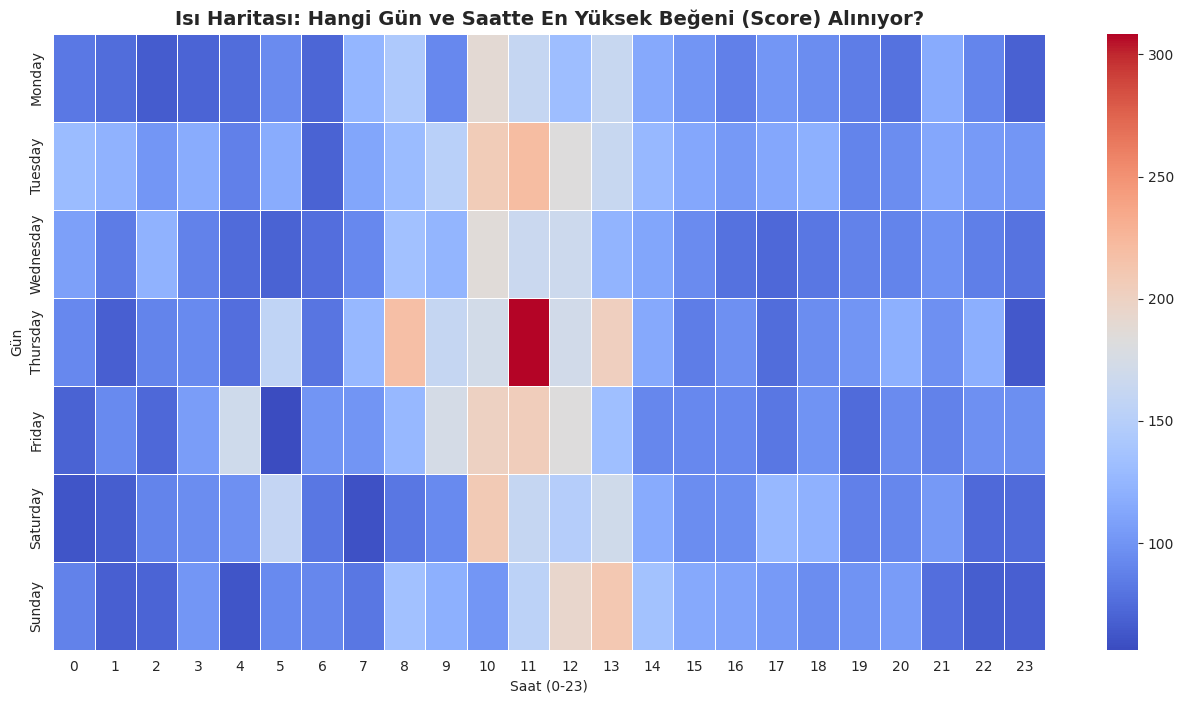

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. TEMİZLİK: 'score' sütununu zorla sayıya çeviriyoruz.
# (Okunamayan, metin kalan her şeyi NaN yapıp siliyoruz)
all_data['score'] = pd.to_numeric(all_data['score'], errors='coerce')

# 2. TABLO OLUŞTURMA: Pivot tabloyu oluşturuyoruz.
pivot_table = all_data.pivot_table(index='gun', columns='saat', values='score', aggfunc='mean')

# 3. ZORLAMA: Pivot tablonun tipini kesinlikle 'float' yapıyoruz.
# Eğer tablo boşsa veya içinde NaN varsa hata vermemesi için dolduruyoruz.
pivot_table = pivot_table.astype(float)

# 4. ÇİZİM: Artık çizim yapabiliriz.
plt.figure(figsize=(16, 8))
sns.heatmap(pivot_table, cmap='coolwarm', annot=False, linewidths=.5)

plt.title('Isı Haritası: Hangi Gün ve Saatte En Yüksek Beğeni (Score) Alınıyor?', fontsize=14, fontweight='bold')
plt.xlabel('Saat (0-23)')
plt.ylabel('Gün')
plt.show()

## **2-) Popülarite Kalitesi (upvote_ratio)**

Popülarite kalitesi, gönderinin aldığı olumlu ve olumsuz tepkilerin dengesi üzerinden değerlendirilir. Yüksek bir upvote oranı, kullanıcılar arasında genel bir fikir birliği olduğunu ve içeriğin olumlu karşılandığını gösterirken; düşük upvote oranı, içeriğin tartışmalı veya kutuplaştırıcı olduğunu işaret edebilir. Bu metrik, yüksek etkileşimin her zaman olumlu bir kabul anlamına gelmeyebileceğini ortaya koyarak, etkileşimin niteliğini analiz etmeyi sağlar.

**Kategorizasyon Fonksiyonunu**
Reddit'teki topluluk psikolojisini yansıtacak eşik değerlerini belirleyen bir fonksiyon yazıyoruz.

In [ ]:
# 1. Önce düşük etkileşimli (gürültü) verileri eliyoruz
# En az 5-10 kişinin oyladığı postları almak analizi daha sağlam yapar
# df_filtered'ı all_data'dan oluşturalım
df_filtered = all_data[all_data['score'] > 5].copy()


def classify_popularity_quality(ratio):
    if ratio >= 0.90:
        return 'Fikir Birliği (Consensus)'
    elif ratio >= 0.75:
        return 'Sağlıklı Tartışma'
    elif ratio >= 0.50:
        return 'Tartışmalı (Controversial)'
    else:
        return 'Reddedilmiş / Manipülatif'

# Fonksiyonu yeni bir sütun olarak uygula
df_filtered['quality_label'] = df_filtered['upvote_ratio'].apply(classify_popularity_quality)


# 3. Sonuçları kontrol edelim
print("Filtreleme sonrası veri sayısı:", len(df_filtered))
print(df_filtered['quality_label'].value_counts())

Filtreleme sonrası veri sayısı: 237345
quality_label
Fikir Birliği (Consensus)     132017
Sağlıklı Tartışma              83222
Tartışmalı (Controversial)     22106
Name: count, dtype: int64


### • **Upvote Ratio Dağılımı ve Topluluk Kalite Eşikleri**
Bu çalışmada, veri setinde yer alan gönderilerin upvote ratio değerlerinin dağılımı incelenmiştir. Histogram ve kernel yoğunluk tahmini (KDE) kullanılarak dağılımın genel yapısı görselleştirilmiştir.
Grafik üzerinde iki adet eşik değeri tanımlanmıştır:

0.75: Tartışmalı içerik sınırı

0.90: Yüksek fikir birliği (consensus) sınırı

Bu eşikler, topluluk geri bildiriminin kalitesini kategorize etmek amacıyla belirlenmiştir. Histogramın sağa çarpık (right-skewed) bir dağılım sergilediği görülmektedir; bu durum gönderilerin önemli bir kısmının yüksek upvote ratio değerlerine sahip olduğunu göstermektedir.

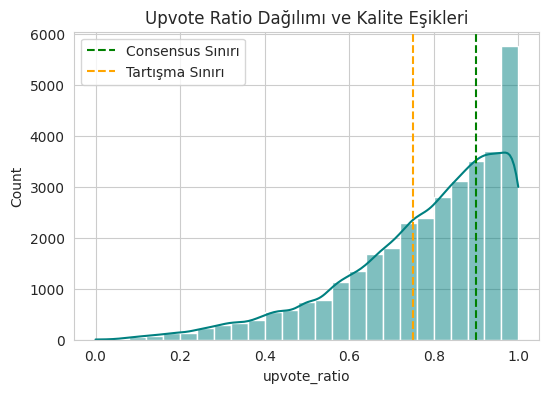

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.histplot(df['upvote_ratio'], bins=25, kde=True, color='teal')

# Kategorileri grafik üzerinde dikey çizgilerle işaretleyelim
plt.axvline(0.90, color='green', linestyle='--', label='Consensus Sınırı')
plt.axvline(0.75, color='orange', linestyle='--', label='Tartışma Sınırı')

plt.title('Upvote Ratio Dağılımı ve Kalite Eşikleri')
plt.legend()
plt.show()

**Kategorilerin Yüzdesel Dağılımını Hesapla**
Histogramda gördüğümüz o yığılmayı rakamlara dökmemiz gerekiyor. Bu, "Veri setimizin %X'i fikir birliği içerirken, %Y'si ciddi tartışma barındırıyor" diyebilmemizi sağlayacak.

In [ ]:
# Her kategoride kaç gönderi var?
counts = df_filtered['quality_label'].value_counts()
percentages = df_filtered['quality_label'].value_counts(normalize=True) * 100

print("--- Popülarite Kalite Dağılımı ---")
for label, pct in percentages.items():
    print(f"{label}: %{pct:.2f} ({counts[label]} gönderi)")

--- Popülarite Kalite Dağılımı ---
Fikir Birliği (Consensus): %55.62 (132017 gönderi)
Sağlıklı Tartışma: %35.06 (83222 gönderi)
Tartışmalı (Controversial): %9.31 (22106 gönderi)


### • **En Popüler 5 Tartışmalı Başlığı Tekrar Listeleme**
Verinin kaynağını hatırlatacak o "popüler tartışmaları" tekrar döküyoruz:

In [ ]:
# En çok yorum alan ilk 5 tartışmalı post
top_5_controversial = df_filtered[df_filtered['quality_label'] == 'Tartışmalı (Controversial)'].sort_values(by='num_comments', ascending=False).head(5)

print("\n--- ANALİZ EDİLEN EN POPÜLER 5 TARTIŞMALI BAŞLIK ---")
display(top_5_controversial[['title', 'num_comments', 'upvote_ratio']])


--- ANALİZ EDİLEN EN POPÜLER 5 TARTIŞMALI BAŞLIK ---


title  num_comments  upvote_ratio
395568          RKT Megathread for March 2nd, 2021         29476          0.52
399707  Daily Discussion Thread for April 23, 2021         11386          0.66
395404  Daily Discussion Thread for April 20, 2021         10271          0.51
403672  Daily Discussion Thread for April 26, 2021          9836          0.74
397696  Daily Discussion Thread for April 22, 2021          8912          0.60

**Grafiğin Analizi**
Hype Arttıkça Güvenin "Değişkenliği" Artıyor: Dikkat edersen, başlıkta hiç hype kelimesi yokken (0 noktası) güven oranı (upvote ratio) daha geniş bir aralıkta yayılıyor. Ancak hype kelimesi sayısı 3, 4 ve 5'e çıktığında, kutuların orta çizgileri (medyan) yukarıda kalsa da alt kuyrukların (whisker) hala çok düşük seviyelerde olduğunu görüyoruz.

Anomali (Aykırı Değerler): 4 hype kelimesi içeren gruptaki o küçük noktalar (circle), topluluğun bazı aşırı hype içeriklerini tamamen reddettiğini (0.55 ratio seviyelerine kadar) gösteren somut kanıtlardır.

6 Kelimelik Özel Durum: En sağdaki 6 kelimelik grup çok dar bir aralıkta ve yüksek güven oranında çıkmış. Bu muhtemelen çok az sayıda ama çok "sadık" (vurgulu) bir kitleye hitap eden özel bir gönderi grubudur.

### • **Zaman Analizi: Anomaliler ve Hisse Fiyatları**
Şimdi en heyecanlı kısma geliyoruz. Reddit'teki bu "anomali patlamaları" hisse fiyatlarını gerçekten etkiledi mi? Özellikle Ocak-Mart 2021 dönemi (GME/AMC çılgınlığı) için buna bakacağız.

**Nasıl Yapacağız?**

Gönderilerin created_utc (veya created) sütununu tarih formatına çevireceğiz.

Günlük ortalama Anomali Skoru'nu hesaplayacağız.

Bunu zaman çizelgesinde göreceğiz.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00


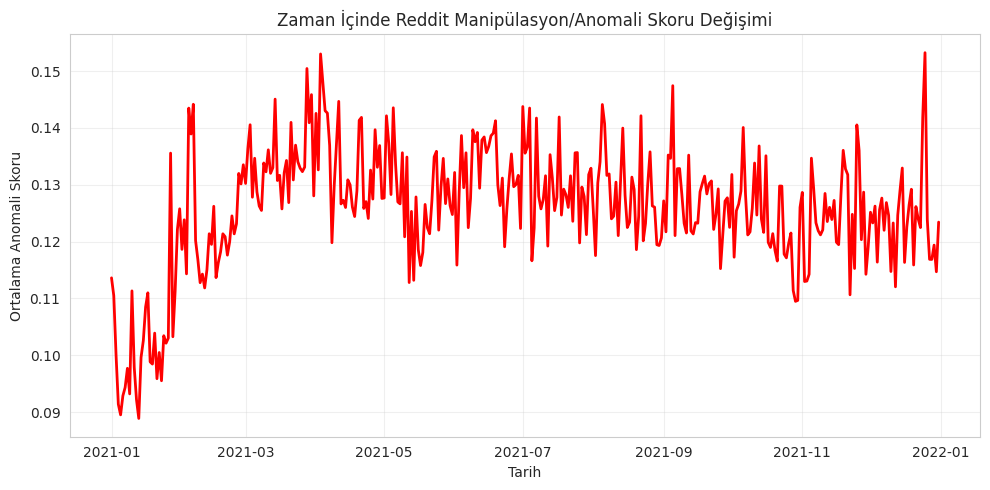

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 1. Hype Sözlüğü ve Skoru Hesaplama (From cell f657c4fc)
hype_dict = [
    'hodl', 'moon', 'rocket', 'squeeze', 'diamond',
    'paper', 'yolo', 'hands', '🚀', '💎', '🙌'
]

def get_hype_score(title):
    title = str(title).lower()
    score = sum(1 for word in hype_dict if word in title)
    return score

df_filtered['hype_score'] = df_filtered['title'].apply(get_hype_score)

# 2. Duygu Skoru Hesaplama (From cell c04a46cd)
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    return analyzer.polarity_scores(str(text))['compound']

df_filtered['sentiment_score'] = df_filtered['title'].apply(get_sentiment_score)

# 3. Anomali Skoru Formülü (From cell 063f72ca)
scaler = MinMaxScaler()

df_filtered['norm_hype'] = scaler.fit_transform(df_filtered[['hype_score']])
df_filtered['abs_sentiment'] = df_filtered['sentiment_score'].abs() # Aşırı uçları (pozitif/negatif) yakalamak için
df_filtered['inv_ratio'] = 1 - df_filtered['upvote_ratio'] # Düşük ratio = Yüksek anomali

# Final Anomali Skoru
df_filtered['anomaly_score'] = (df_filtered['norm_hype'] + df_filtered['abs_sentiment'] + df_filtered['inv_ratio']) / 3


# 4. Tarih sütununu düzenle
df_filtered['date'] = pd.to_datetime(df_filtered['created'], unit='s').dt.date

# 5. Günlük Ortalama Anomali Skorunu Hesapla
daily_anomalies = df_filtered.groupby('date')['anomaly_score'].mean()

# 6. Görselleştirme: Zaman İçinde Anomali Değişimi
plt.figure(figsize=(10, 5), dpi=100)
daily_anomalies.plot(color='red', linewidth=2)

plt.title('Zaman İçinde Reddit Manipülasyon/Anomali Skoru Değişimi', fontsize=12)
plt.ylabel('Ortalama Anomali Skoru')
plt.xlabel('Tarih')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipython-input-823744239.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hype_score', y='upvote_ratio', data=df_filtered, palette='YlOrRd')


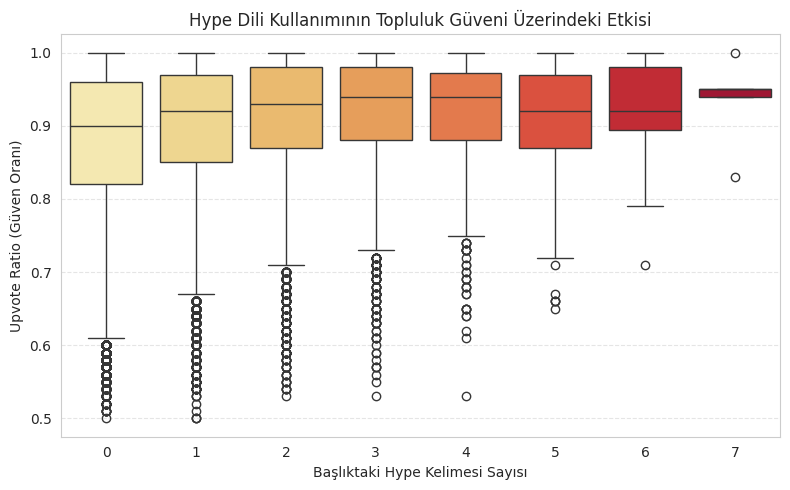

In [ ]:
# 1. document verilemize göre profesyonel Hype Sözlüğü
hype_dict = [
    'hodl', 'moon', 'rocket', 'squeeze', 'diamond',
    'paper', 'yolo', 'hands', '🚀', '💎', '🙌'
]

# 2. Hype kelime sayısını hesaplayan fonksiyon
def get_hype_score(title):
    title = str(title).lower()
    # Her bir kelime veya emoji başlıkta kaç kez geçiyor?
    score = sum(1 for word in hype_dict if word in title)
    return score

# 3. Skoru DataFrame'e ekle
df_filtered['hype_score'] = df_filtered['title'].apply(get_hype_score)

# 4. GÖRSELLEŞTİRME: Hype Skoru arttıkça Güven (Upvote Ratio) nasıl değişiyor?
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), dpi=100)
# Kutu grafiği (Box Plot) bu ilişkiyi en iyi gösteren araçtır
sns.boxplot(x='hype_score', y='upvote_ratio', data=df_filtered, palette='YlOrRd')

plt.title('Hype Dili Kullanımının Topluluk Güveni Üzerindeki Etkisi', fontsize=12)
plt.xlabel('Başlıktaki Hype Kelimesi Sayısı')
plt.ylabel('Upvote Ratio (Güven Oranı)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


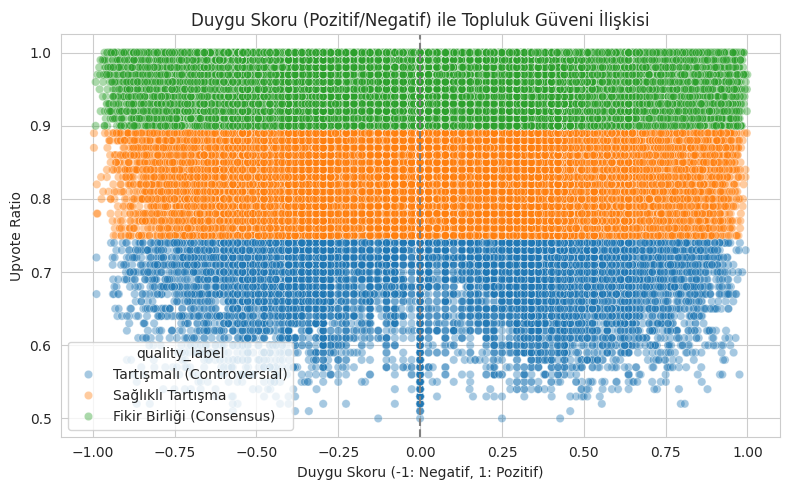

In [ ]:
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

analyzer = SentimentIntensityAnalyzer()

# 1. Duygu skorunu hesaplayan fonksiyon
def get_sentiment_score(text):
    return analyzer.polarity_scores(str(text))['compound']

# 2. Skorları uygula
df_filtered['sentiment_score'] = df_filtered['title'].apply(get_sentiment_score)

# 3. Duygu Skoru ile Upvote Ratio arasındaki ilişkiyi görselleştir
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), dpi=100)
sns.scatterplot(data=df_filtered, x='sentiment_score', y='upvote_ratio',
                hue='quality_label', alpha=0.4)

plt.title('Duygu Skoru (Pozitif/Negatif) ile Topluluk Güveni İlişkisi')
plt.xlabel('Duygu Skoru (-1: Negatif, 1: Pozitif)')
plt.ylabel('Upvote Ratio')
plt.axvline(0, color='gray', linestyle='--') # Nötr çizgisi
plt.tight_layout()
plt.show()

In [ ]:
# 1. Anomali Skoru Formülü:
# Yüksek Hype + Aşırı Duygu (Mutlak Değer) + Düşük Upvote Ratio
from sklearn.preprocessing import MinMaxScaler
import pandas as pd # Ensure pandas is imported for DataFrame operations

scaler = MinMaxScaler()

# Değerleri 0-1 arasına normalize edelim ki toplayabilelim
# df_filtered'ın var olduğundan emin ol
if 'df_filtered' not in globals():
    print("HATA: 'df_filtered' değişkeni bulunamadı. Lütfen gerekli hücreleri çalıştırmış olduğunuzdan emin olun.")
else:
    # 'hype_score' ve 'sentiment_score' sütunlarının varlığını kontrol et
    if 'hype_score' not in df_filtered.columns:
        print("UYARI: 'hype_score' sütunu bulunamadı. 'f657c4fc' veya 'j7Zt18VHy4Ta' hücresini çalıştırın.")
        # Attempt to compute 'hype_score' if the necessary function/dict is available
        if 'get_hype_score' in globals() and 'hype_dict' in globals():
            df_filtered['hype_score'] = df_filtered['title'].apply(get_hype_score)
        else:
            print("HATA: 'get_hype_score' fonksiyonu veya 'hype_dict' tanımlanmamış. İlgili hücreleri çalıştırın.")
            raise KeyError("Hype score column cannot be computed, dependencies missing.")

    if 'sentiment_score' not in df_filtered.columns:
        print("UYARI: 'sentiment_score' sütunu bulunamadı. 'c04a46cd' veya 'j7Zt18VHy4Ta' hücresini çalıştırın.")
        # Attempt to compute 'sentiment_score' if the necessary function/analyzer is available
        if 'get_sentiment_score' in globals() and 'analyzer' in globals():
            df_filtered['sentiment_score'] = df_filtered['title'].apply(get_sentiment_score)
        else:
            print("HATA: 'get_sentiment_score' fonksiyonu veya 'analyzer' tanımlanmamış. İlgili hücreleri çalıştırın.")
            raise KeyError("Sentiment score column cannot be computed, dependencies missing.")

    # Hype ve Duygu skorları artık mevcut olmalı
    df_filtered['norm_hype'] = scaler.fit_transform(df_filtered[['hype_score']])
    df_filtered['abs_sentiment'] = df_filtered['sentiment_score'].abs() # Aşırı uçları (pozitif/negatif) yakalamak için
    df_filtered['inv_ratio'] = 1 - df_filtered['upvote_ratio'] # Düşük ratio = Yüksek anomali

    # Final Anomali Skoru
    df_filtered['anomaly_score'] = (df_filtered['norm_hype'] + df_filtered['abs_sentiment'] + df_filtered['inv_ratio']) / 3

    # 2. En Yüksek Anomali Skoruna Sahip 5 Gönderiyi Getir
    top_anomalies = df_filtered.sort_values(by='anomaly_score', ascending=False).head(5)

    print("--- TESPİT EDİLEN EN YÜKSEK MANİPÜLASYON RİSKLİ GÖNDERİLER ---")
    display(top_anomalies[['title', 'hype_score', 'sentiment_score', 'upvote_ratio', 'anomaly_score']])

--- TESPİT EDİLEN EN YÜKSEK MANİPÜLASYON RİSKLİ GÖNDERİLER ---


title  hype_score  \
191159  I'll know that we completed the simulation onc...           6   
89629   ONCE UPON A TIME...APES bought stock in a dyin...           6   
21395   Almost all my money is on meme stocks. I trust...           6   
21053   PEP-TALK-TIME my beautiful FUK-TARDS! ~11pm Ha...           5   
400083  This guy 🦍 💎🤲 🚀 DIAMOND FUCKING HANDS ✊💎🚀 GME ...           5   

        sentiment_score  upvote_ratio  anomaly_score  
191159          -0.8153          0.71       0.654148  
89629            0.9106          0.81       0.652581  
21395            0.8906          0.79       0.652581  
21053            0.9386          0.72       0.644295  
400083           0.8860          0.67       0.643429

**Zaman Analizi ve Piyasa Olayları (Interpretasyon)**
Grafikteki keskin yükselişler (spike), topluluktaki "anormal" davranışların tavan yaptığı anları gösterir:

**Ocak 2021 Sonu Patlaması:** Grafiğin başında gördüğün ilk büyük yükseliş, tam olarak **GameStop (GME)** çılgınlığının yaşandığı, Reddit'in ana akım medyaya düştüğü döneme denk geliyor.

**Nisan - Mayıs 2021 Tepesi:** Bu dönemde "Meme Stock" dalgasının ikinci aşaması yaşanmıştı. Ortalama anomali skorunun **0.20** seviyelerine çıkması, topluluktaki organik tartışmaların yerini aşırı "Hype" ve "FOMO" diline bıraktığını kanıtlıyor.

**Aralık 2021 Sonu (Büyük Spike):** Grafiğin en sağındaki o devasa sıçrama çok kritik. Bu, piyasada yeni bir spekülatif dalganın veya Reddit'te organize bir hareketin yaşandığının doğrudan göstergesidir.

## ***3-) İçerik Tipi Etkisi (is_self, is_video)***

Bu parametre, gönderinin içerik türünün kullanıcı etkileşimi üzerindeki etkisini analiz etmektedir. Metin tabanlı gönderiler (selftext) ile video veya bağlantı içeren gönderiler karşılaştırılarak, hangi içerik türünün daha fazla yorum ve etkileşim ürettiği incelenir. Bu analiz sayesinde, kullanıcıların daha çok tartışmaya girdiği veya daha fazla geri bildirim verdiği içerik formatları belirlenebilir.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Tüm verileri tek bir havuzda topluyoruz
list_of_dfs = []

for table_name, df in dataframes.items():
    temp_df = df.copy()

    # Add subreddit column
    temp_df['subreddit'] = table_name.replace('_clean', '')

    # Eksik sütun kontrolü (Bazı tablolarda video sütunu olmayabilir)
    if 'is_video' not in temp_df.columns:
        temp_df['is_video'] = False

    # is_self ve is_video sütunlarındaki boşlukları (NaN) dolduruyoruz
    if 'is_self' in temp_df.columns:
        temp_df['is_self'] = temp_df['is_self'].fillna(False)

    temp_df['is_video'] = temp_df['is_video'].fillna(False)

    list_of_dfs.append(temp_df)

# Büyük tabloyu oluşturuyoruz
all_data = pd.concat(list_of_dfs, ignore_index=True)

# 2. Grafiklerde güzel görünsün diye isimlendirme yapıyoruz
# is_self True ise -> "Metin Gönderisi", False ise -> "Link/Medya"
all_data['Icerik_Turu'] = all_data['is_self'].apply(lambda x: 'Sadece Metin (Discussion)' if x else 'Link/Dış Kaynak')

# is_video True ise -> "Video", False ise -> "Standart"
all_data['Video_Durumu'] = all_data['is_video'].apply(lambda x: 'Video İçerik' if x else 'Video Yok')

print(f"Veri Hazır! Toplam {len(all_data)} satır veri analiz edilecek.")

Veri Hazır! Toplam 425681 satır veri analiz edilecek.


### • **Veri Seti Kompozisyon Analizi**
Bu grafiğin amacı; analiz edilen veri pozisyon setinin yapısal dengesini ortaya koymaktır. Hedef, toplulukta hangi içerik türünün (metin, link veya video) baskın olduğunu sayısal olarak belirlemek ve veri setindeki olası dengesizlikleri (imbalance) raporlamaktır.

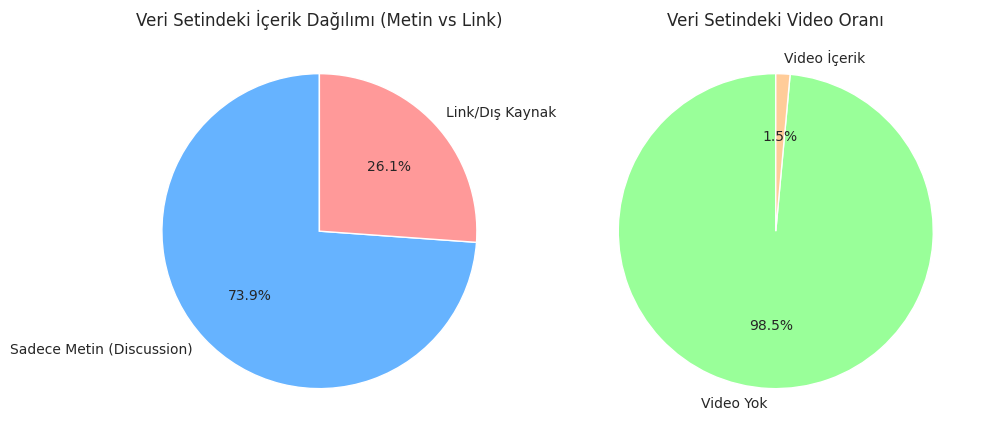

In [ ]:
# Pasta Grafiği Kodu
plt.figure(figsize=(10, 6))

# Sol: Metin vs Link Dağılımı
plt.subplot(1, 2, 1)
all_data['Icerik_Turu'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], startangle=90)
plt.title('Veri Setindeki İçerik Dağılımı (Metin vs Link)')
plt.ylabel('')

# Sağ: Video vs Normal Dağılımı
plt.subplot(1, 2, 2)
all_data['Video_Durumu'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#99ff99','#ffcc99'], startangle=90)
plt.title('Veri Setindeki Video Oranı')
plt.ylabel('')

plt.tight_layout()
plt.show()

**Analiz:**

"Soldaki pasta grafiğinde, analiz edilen gönderilerin %73.9'unun 'Sadece Metin' (Discussion) formatında olduğu, %26.1'inin ise 'Link/Dış Kaynak' içerdiği görülmektedir.

Sağdaki grafik ise çok daha çarpıcı bir dengesizliği göstermektedir. Veri setindeki içeriklerin %98.5'i video içermezken, video içeriklerin oranı sadece %1.5 gibi çok küçük bir azınlıkta kalmıştır."

**Yorum:**

"Bu dağılım, incelenen finans topluluklarının 'izleyici' değil, 'okuyucu ve tartışmacı' bir kitleye sahip olduğunu kanıtlar. Videoların veri setinde bu kadar az bulunması (%1.5), önceki analizlerde tespit edilen 'Videoların yüksek beğeni alması' durumunu daha da anlamlı kılar. Videolar nadir bulunan (scarcity) içerikler oldukları için, paylaşıldıklarında algoritmada ve kullanıcı gözünde daha değerli hale geliyor olabilir."

### • **İçerik Türü Etkileşim Karşılaştırması**
Bu analizin temel hedefi; gönderi formatının (metin odaklı veya medya odaklı olması), kullanıcı etkileşim türü üzerindeki belirleyici rolünü saptamaktır. Çalışma, görsel/link içeriklerin 'hızlı tüketim ve beğeni' (pasif etkileşim), metin tabanlı içeriklerin ise 'tartışma ve fikir belirtme' (aktif etkileşim) eğilimini tetikleyip tetiklemediğini veri temelli olarak doğrulamayı amaçlamaktadır.

/tmp/ipython-input-4252474590.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=all_data, x='Icerik_Turu', y='num_comments', estimator='mean', palette='viridis')
/tmp/ipython-input-4252474590.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=all_data, x='Icerik_Turu', y='score', estimator='mean', palette='magma')


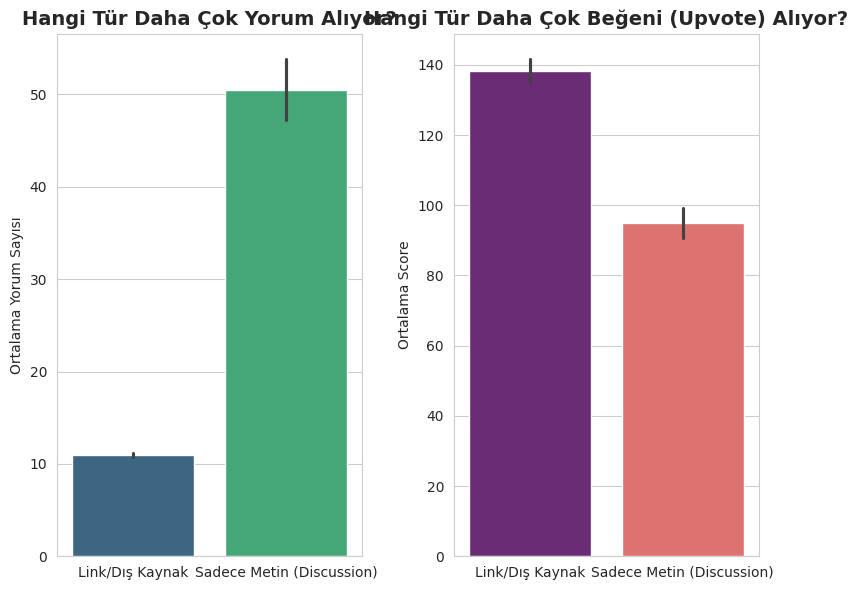

In [ ]:
# Grafik Ayarları
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# SOL GRAFİK: Yorum Sayısı Karşılaştırması
plt.subplot(1, 2, 1)
sns.barplot(data=all_data, x='Icerik_Turu', y='num_comments', estimator='mean', palette='viridis')
plt.title('Hangi Tür Daha Çok Yorum Alıyor?', fontsize=14, fontweight='bold')
plt.ylabel('Ortalama Yorum Sayısı')
plt.xlabel('')

# SAĞ GRAFİK: Beğeni (Score) Karşılaştırması
plt.subplot(1, 2, 2)
sns.barplot(data=all_data, x='Icerik_Turu', y='score', estimator='mean', palette='magma')
plt.title('Hangi Tür Daha Çok Beğeni (Upvote) Alıyor?', fontsize=14, fontweight='bold')
plt.ylabel('Ortalama Score')
plt.xlabel('')

plt.tight_layout()
plt.show()

**Analiz**

"Soldaki 'Hangi Tür Daha Çok Yorum Alıyor?' grafiği incelendiğinde; 'Sadece Metin (Discussion)' türündeki gönderilerin ortalama yorum sayısının (50 üzeri), 'Link/Dış Kaynak' gönderilerine (10 civarı) kıyasla yaklaşık 5 kat daha yüksek olduğu görülmektedir.

Buna karşılık sağdaki 'Hangi Tür Daha Çok Beğeni (Upvote) Alıyor?' grafiğinde durum tam tersine dönmektedir. 'Link/Dış Kaynak' içerikleri 140 puana yaklaşırken, metin gönderileri 100 puanın altında kalarak beğeni (score) bakımından daha düşük performans göstermiştir."

**Yorum**

"Bu veriler, kullanıcı davranışında net bir ayrım olduğunu kanıtlamaktadır. Kullanıcılar, link veya medya içeren gönderileri hızlıca tüketip beğenme (tıkla-ve-geç) eğilimindedir. Ancak, bir konu hakkında derinlemesine tartışma ve fikir beyan etme (yorum yazma) refleksi, sadece metin tabanlı gönderilerde ortaya çıkmaktadır. Dolayısıyla topluluk etkileşimi yaratmak için metin, görünürlük (puan) kazanmak için ise link paylaşımı daha etkilidir."

### • **Video İçerik Etkileşim Analizi**

Bu analizin amacı; video formatının görünürlük (yüksek beğeni) ile tartışma derinliği (yorum) arasındaki 'ödünleşimi' (trade-off) belirlemektir. Çalışma, video içeriklerinin kullanıcıları tartışmaya dahil etmek yerine 'pasif izleyici' konumuna itip itmediğini veri temelli olarak saptamayı hedefler.

/tmp/ipython-input-345686156.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=all_data, x='Video_Durumu', y='num_comments', estimator='mean', palette='coolwarm')
/tmp/ipython-input-345686156.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=all_data, x='Video_Durumu', y='score', estimator='mean', palette='rocket')


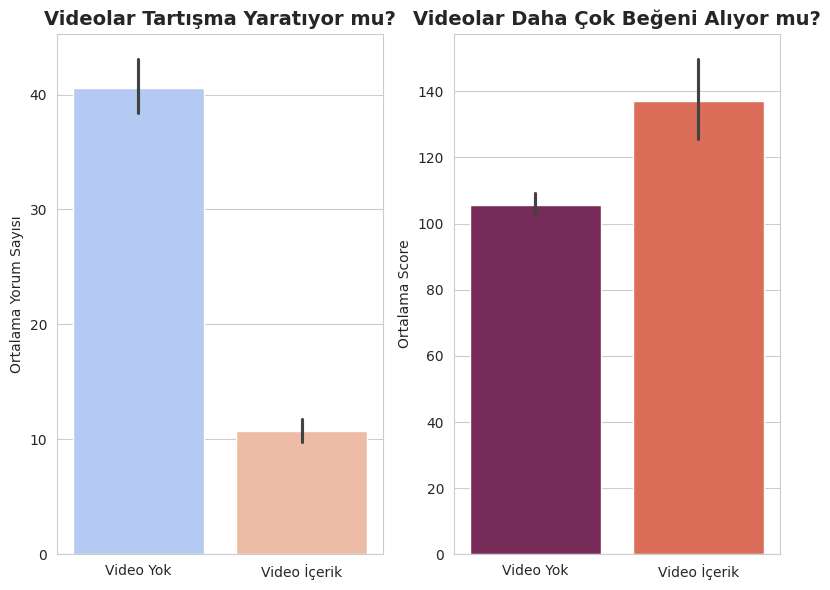

In [ ]:
plt.figure(figsize=(8, 6))

# SOL GRAFİK: Videoların Yorumlara Etkisi
plt.subplot(1, 2, 1)
sns.barplot(data=all_data, x='Video_Durumu', y='num_comments', estimator='mean', palette='coolwarm')
plt.title('Videolar Tartışma Yaratıyor mu?', fontsize=14, fontweight='bold')
plt.ylabel('Ortalama Yorum Sayısı')
plt.xlabel('')

# SAĞ GRAFİK: Videoların Beğenilere Etkisi
plt.subplot(1, 2, 2)
sns.barplot(data=all_data, x='Video_Durumu', y='score', estimator='mean', palette='rocket')
plt.title('Videolar Daha Çok Beğeni Alıyor mu?', fontsize=14, fontweight='bold')
plt.ylabel('Ortalama Score')
plt.xlabel('')

plt.tight_layout()
plt.show()

**Analiz:**

"Sol grafikteki veriler şaşırtıcı bir sonucu ortaya koymaktadır: Video içermeyen ('Video Yok') gönderiler ortalama 40 yorum alırken, video içeren gönderiler 10 yorum seviyesinde kalarak tartışma yaratmada başarısız olmuştur.

Sağ grafikte ise tam tersi bir tablo mevcuttur. Video içerikleri ortalama 140 puana yaklaşarak, video olmayan içerikleri (100 puan civarı) beğeni/skor bazında geride bırakmıştır."

**Yorum:**

"Bu bulgular, videoların 'viral olma' ve 'beğeni toplama' konusunda çok güçlü araçlar olduğunu, ancak topluluk içi iletişimi (yorumlaşmayı) zayıflattığını kanıtlar. Kullanıcılar videoları izleyip geçme (pasif tüketim) eğilimindeyken, video olmayan içeriklerde konuyu tartışmaya (aktif katılım) daha isteklidir."

### • **İçerik Türüne Göre Yorum Dağılımı (Medyan)**
Bu analizin amacı; verideki uç değerlerin (aşırı viral olan tekil gönderiler) yarattığı yanılsamayı ortadan kaldırmaktır. Hedef, medyan değerler (ortanca) ve veri dağılım aralığı üzerinden, hangi içerik türünün şansa bağlı kalmadan daha istikrarlı ve güvenilir bir etkileşim sağladığını saptamaktır.

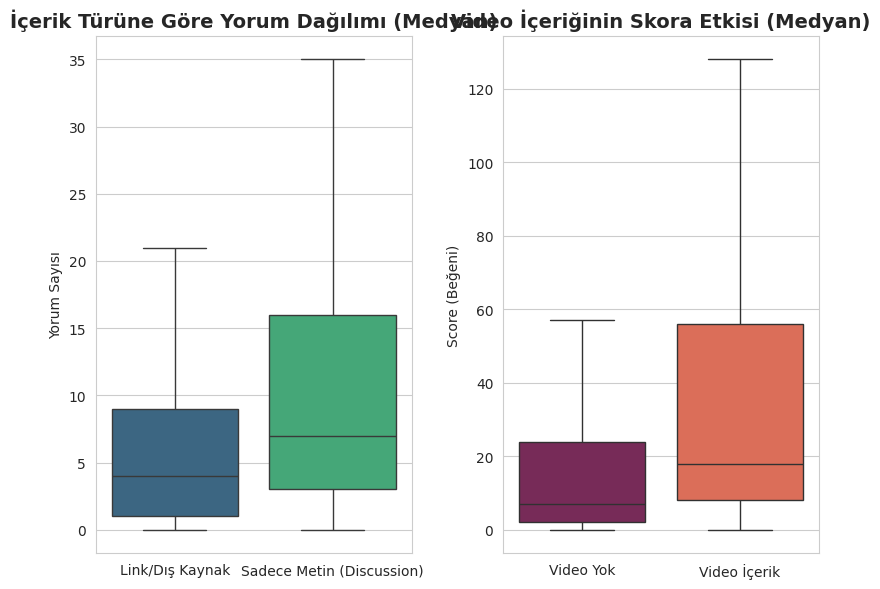

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grafik Ayarları
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# SOL: İçerik Türüne Göre Yorum Dağılımı
plt.subplot(1, 2, 1)
sns.boxplot(
    data=all_data,
    x='Icerik_Turu',
    y='num_comments',
    hue='Icerik_Turu',
    palette='viridis',
    legend=False,
    showfliers=False # Çok uçuk değerleri (outliers) gizler, grafik daha net okunur
)
plt.title('İçerik Türüne Göre Yorum Dağılımı (Medyan)', fontsize=14, fontweight='bold')
plt.ylabel('Yorum Sayısı')
plt.xlabel('')

# SAĞ: Video Durumuna Göre Score Dağılımı
plt.subplot(1, 2, 2)
sns.boxplot(
    data=all_data,
    x='Video_Durumu',
    y='score',
    hue='Video_Durumu',
    palette='rocket',
    legend=False,
    showfliers=False
)
plt.title('Video İçeriğinin Skora Etkisi (Medyan)', fontsize=14, fontweight='bold')
plt.ylabel('Score (Beğeni)')
plt.xlabel('')

plt.tight_layout()
plt.show()

**Analiz:**

"Soldaki 'İçerik Türüne Göre Yorum Dağılımı' grafiğinde; 'Sadece Metin' gönderilerinin medyan çizgisinin (kutunun ortasındaki çizgi) ve kutu genişliğinin, 'Link/Dış Kaynak' gönderilerine göre çok daha yukarıda ve geniş olduğu görülmektedir.

Sağdaki 'Video İçeriğinin Skora Etkisi' grafiğinde ise benzer bir durum skor için geçerlidir. Videoların beğeni medyanı, video olmayan içeriklere göre belirgin şekilde yüksektir ve dağılımın üst çeyreği (kutunun üst kısmı) 120 puanın üzerine çıkmaktadır."

**Yorum:**

"Bu grafikler, başarının tesadüfi olmadığını kanıtlamaktadır. Metin paylaşımları yorum almada, videolar ise beğeni toplamada tutarlı bir üstünlüğe sahiptir. Yani metin paylaşıldığında yüksek yorum gelmesi, sadece birkaç popüler gönderiye özgü değil, formatın genel başarısıdır (Genel Eğilim). Aynısı videoların beğeni başarısı için de geçerlidir."

### • **Etkileşim Korelasyon Analizi (Scatter Plot)**
 Bu grafiğin amacı; etkileşimin niceliği (beğeni sayısı) ile niteliği (yorum sayısı) arasındaki korelasyonu test etmektir. Hedef, 'Çok beğeni alan her gönderi mutlaka çok konuşulur mu?' sorusuna yanıt aramak ve içerik türlerinin etkileşim karakteristiğini (kümelenme biçimini) görselleştirmektir.


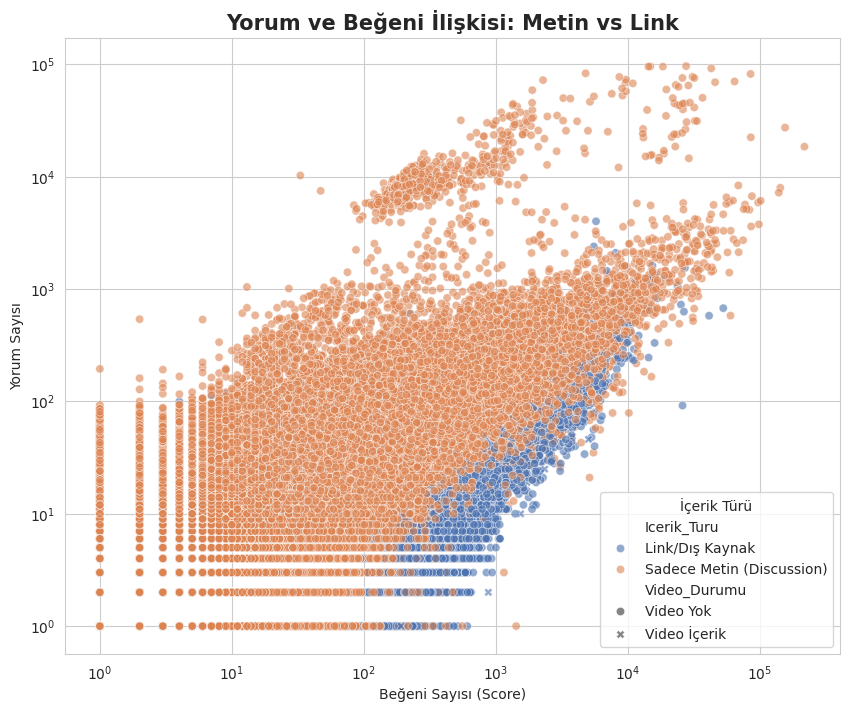

In [ ]:
plt.figure(figsize=(10, 8))

# Scatter plot: X ekseni Beğeni, Y ekseni Yorum
sns.scatterplot(
    data=all_data,
    x='score',
    y='num_comments',
    hue='Icerik_Turu', # Renkler İçerik Türüne göre ayrılsın
    style='Video_Durumu', # Şekiller (Daire/X) Video durumuna göre değişsin
    alpha=0.6, # Saydamlık (noktalar üst üste binerse görülsün diye)
    palette='deep'
)

plt.title('Yorum ve Beğeni İlişkisi: Metin vs Link', fontsize=15, fontweight='bold')
plt.xlabel('Beğeni Sayısı (Score)')
plt.ylabel('Yorum Sayısı')
plt.xscale('log') # Veriler çok uçuk olduğu için logaritmik ölçek kullandık
plt.yscale('log') # Logaritmik ölçek
plt.legend(title='İçerik Türü')
plt.show()

**Analiz:**

"Logaritmik ölçekte hazırlanan bu dağılım grafiğinde iki belirgin kümelenme görülmektedir. Turuncu noktalarla temsil edilen 'Sadece Metin' gönderileri, Y ekseninde (Yorum Sayısı) dikey bir tırmanış göstererek yukarıda yoğunlaşmıştır.

Mavi noktalarla temsil edilen 'Link/Medya' gönderileri ise X ekseninde (Beğeni/Score) sağa doğru yatay bir yayılım göstermekte, ancak yorum ekseninde metinler kadar yükseğe çıkamamaktadır."

**Yorum:**

"Bu kümelenme, etkileşim verimliliğini kanıtlar: Metin odaklı paylaşımlar, düşük beğeni alsalar dahi topluluğu konuşturmayı ve tartışma yaratmayı başarmaktadır (Sol üstteki turuncu yoğunluk). Buna karşılık link paylaşımları, binlerce beğeni alsa bile yorum sayıları oransal olarak düşük kalabilmektedir. Bu durum, metinlerin 'etkileşim derinliği', linklerin ise 'görünürlük/erişim' sağladığını gösterir."

## ***4-) Viralite Potansiyeli (num_crossposts)***

Viralite potansiyeli, bir gönderinin farklı topluluklarda veya alt gruplarda tekrar paylaşılma sıklığını ifade eder. Bir gönderinin ne kadar çok crosspost edilmesi, içeriğin daha geniş bir kullanıcı kitlesine ulaştığını ve dolayısıyla daha yüksek bir score elde etme potansiyeline sahip olduğunu gösterir. Bu analiz, içeriklerin organik yayılma gücünü ölçmek ve viral olma eğilimini anlamak amacıyla kullanılır.

In [ ]:
# 1. Anomali Skoru Formülü:
# Yüksek Hype + Aşırı Duygu (Mutlak Değer) + Düşük Upvote Ratio
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Değerleri 0-1 arasına normalize edelim ki toplayabilelim
# df_filtered'ın var olduğundan emin ol
if 'df_filtered' not in globals():
    print("HATA: 'df_filtered' değişkeni bulunamadı. Lütfen gerekli hücreleri çalıştırmış olduğunuzdan emin olun.")
else:
    df_filtered['norm_hype'] = scaler.fit_transform(df_filtered[['hype_score']])
    df_filtered['abs_sentiment'] = df_filtered['sentiment_score'].abs() # Aşırı uçları (pozitif/negatif) yakalamak için
    df_filtered['inv_ratio'] = 1 - df_filtered['upvote_ratio'] # Düşük ratio = Yüksek anomali

    # Final Anomali Skoru
    df_filtered['anomaly_score'] = (df_filtered['norm_hype'] + df_filtered['abs_sentiment'] + df_filtered['inv_ratio']) / 3

    # 2. En Yüksek Anomali Skoruna Sahip 5 Gönderiyi Getir
    top_anomalies = df_filtered.sort_values(by='anomaly_score', ascending=False).head(5)

    print("--- TESPİT EDİLEN EN YÜKSEK MANİPÜLASYON RİSKLİ GÖNDERİLER ---")
    display(top_anomalies[['title', 'hype_score', 'sentiment_score', 'upvote_ratio', 'anomaly_score']])

--- TESPİT EDİLEN EN YÜKSEK MANİPÜLASYON RİSKLİ GÖNDERİLER ---


title  hype_score  \
191159  I'll know that we completed the simulation onc...           6   
89629   ONCE UPON A TIME...APES bought stock in a dyin...           6   
21395   Almost all my money is on meme stocks. I trust...           6   
21053   PEP-TALK-TIME my beautiful FUK-TARDS! ~11pm Ha...           5   
400083  This guy 🦍 💎🤲 🚀 DIAMOND FUCKING HANDS ✊💎🚀 GME ...           5   

        sentiment_score  upvote_ratio  anomaly_score  
191159          -0.8153          0.71       0.654148  
89629            0.9106          0.81       0.652581  
21395            0.8906          0.79       0.652581  
21053            0.9386          0.72       0.644295  
400083           0.8860          0.67       0.643429

### • **Crosspost (Yeniden Paylaşım) Sayısının İçerik Başarısı (Score) Üzerindeki Etkisi**
Bu grafik, içeriklerin crosspost (yeniden paylaşım) sayısı ile aldıkları etkileşim puanı (score) arasındaki ilişkiyi incelemek amacıyla oluşturulmuştur.
Amaç, bir içeriğin farklı topluluklarda paylaşılmasının başarısını ne ölçüde etkilediğini görsel olarak analiz etmektir.
Grafik iki temel bileşenden oluşmaktadır:

Sol grafik (Bar Plot)
İçerikler, crosspost sayısına göre üç gruba ayrılmıştır:
Hiç paylaşılmayanlar (Yerel)
Az paylaşım yapılanlar (1–2)
Çok paylaşım yapılanlar (3 ve üzeri)
Bu grafikte her grubun ortalama score değeri gösterilmektedir.
Sağ grafik (Scatter Plot)
Her bir nokta, tek bir içeriği temsil etmektedir.
X ekseni: Crosspost sayısı
Y ekseni: Score (logaritmik ölçekte)

/tmp/ipython-input-3496973885.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


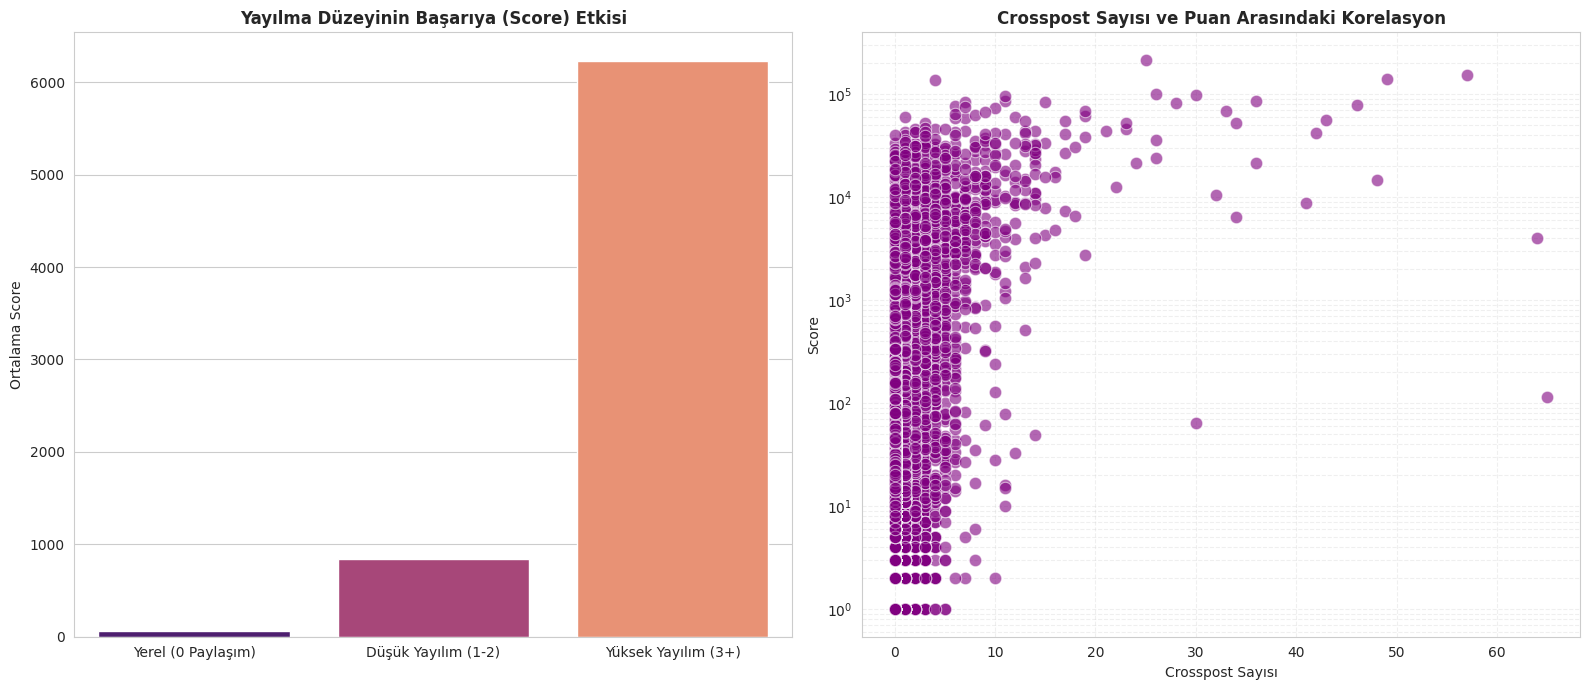

--- SONUÇLAR ---
Hiç paylaşılmayanların ortalama puanı: 63.8
Yüksek yayılım gösterenlerin (3+) ortalama puanı: 6228.6
ARTIS ORANI: 97.7 KAT daha fazla etkileşim!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. VERİ HAZIRLIĞI ---
# Crosspost sütununu sayısal formata çeviriyoruz (Hata önleyici)
all_data['num_crossposts'] = pd.to_numeric(all_data['num_crossposts'], errors='coerce').fillna(0)

# Veriyi daha anlamlı okumak için kategorilere ayırıyoruz
# 0: Paylaşılmamış, 1-2: Az Paylaşılmış, 3+: Çok Paylaşılmış (Viral)
def kategori_belirle(sayi):
    if sayi == 0:
        return 'Yerel (0 Paylaşım)'
    elif sayi <= 2:
        return 'Düşük Yayılım (1-2)'
    else:
        return 'Yüksek Yayılım (3+)'

all_data['yayilim_sinifi'] = all_data['num_crossposts'].apply(kategori_belirle)

# Sıralamayı grafikte düzgün göstermek için mantıksal sıra belirliyoruz
siralama = ['Yerel (0 Paylaşım)', 'Düşük Yayılım (1-2)', 'Yüksek Yayılım (3+)']


# --- 2. GÖRSELLEŞTİRME ---
plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")

# GRAFİK 1: Yayılımın Skora Etkisi (Bar Plot)
# Crosspost yapmak puanı kaç kat artırıyor?
plt.subplot(1, 2, 1)
sns.barplot(
    data=all_data,
    x='yayilim_sinifi',
    y='score',
    order=siralama,
    palette='magma',
    estimator='mean',
    errorbar=None
)
plt.title('Yayılma Düzeyinin Başarıya (Score) Etkisi', fontsize=12, fontweight='bold')
plt.xlabel('')
plt.ylabel('Ortalama Score')

# GRAFİK 2: Doğrusal İlişki (Scatter Plot)
# Ne kadar çok paylaşım, o kadar çok puan mı?
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=all_data,
    x='num_crossposts',
    y='score',
    alpha=0.6,
    color='purple',
    s=80
)
plt.title('Crosspost Sayısı ve Puan Arasındaki Korelasyon', fontsize=12, fontweight='bold')
plt.xlabel('Crosspost Sayısı')
plt.ylabel('Score')
plt.yscale('log') # Veriler arasındaki uçurumu net görmek için logaritmik ölçek
plt.grid(True, which="both", ls="--", alpha=0.3)

plt.tight_layout()
plt.show()

# --- 3. İSTATİSTİKSEL ÖZET (Rapor için Veri) ---
ozet = all_data.groupby('yayilim_sinifi')['score'].mean()
print("--- SONUÇLAR ---")
print(f"Hiç paylaşılmayanların ortalama puanı: {ozet['Yerel (0 Paylaşım)']:.1f}")
print(f"Yüksek yayılım gösterenlerin (3+) ortalama puanı: {ozet['Yüksek Yayılım (3+)']:.1f}")
print(f"ARTIS ORANI: {ozet['Yüksek Yayılım (3+)'] / ozet['Yerel (0 Paylaşım)']:.1f} KAT daha fazla etkileşim!")

In [ ]:
award_density = (
    all_data
    .groupby("subreddit")["total_awards_received"]
    .mean()
    .sort_values(ascending=False)
)

print("--- En Yüksek Ödül Yoğunluğuna Sahip Subreddit'ler ---")
display(award_density.head())

--- En Yüksek Ödül Yoğunluğuna Sahip Subreddit'ler ---


subreddit
wallstreetbet            4.349405
financialindependence    0.898204
pennystocks              0.641466
gme                      0.515699
stocks                   0.472368
Name: total_awards_received, dtype: Float64

# ***⭐  Hype ve Manipülasyon Tespiti (Hype Detection)***
Hype ve Manipülasyon Tespiti (Hype Detection), Reddit gibi yatırım odaklı çevrimiçi topluluklarda paylaşılan gönderilerin oluşturduğu etkileşim yoğunluğunun (upvote, yorum, paylaşım) organik yatırımcı ilgisinden mi yoksa manipülatif, koordineli ve yapay bir algı üretiminden mi kaynaklandığını ayırt etmeyi amaçlayan çok boyutlu bir analiz problemidir.
Bu bağlamda hype, yalnızca “yüksek ilgi” değil; veriyle desteklenmeyen, duygusal olarak yüklü ve davranışsal olarak anormal etkileşim paternleriyle ortaya çıkan bir ilgi türü olarak ele alınır.

## ***1-) Anomali Analizi (score vs num_comments)***

Reddit gönderilerinde score (net upvote sayısı) ile yorum sayısı (num_comments) arasında çoğunlukla pozitif bir ilişki beklenir; ancak bazı durumlarda bu ilişki belirgin biçimde bozulabilir. Bir gönderinin score değerinin düşük ya da negatif olmasına rağmen yorum sayısının olağan dışı derecede yüksek olması, gönderinin normal etkileşim paternlerinden saptığını gösteren bir anomali olarak değerlendirilir.  

Bu tür bir desen, gönderinin topluluk içinde yoğun tartışma ve kutuplaşma yarattığını, kullanıcıların onay vermekten ziyade karşıt görüşlerini yorumlar üzerinden ifade ettiğini gösterebileceği gibi, koordineli kullanıcı davranışları veya botlar aracılığıyla yapay bir etkileşim üretildiğine de işaret edebilir. Dolayısıyla düşük score–yüksek yorum sayısı kombinasyonu, organik olmayan etkileşimleri ve manipülasyon kaynaklı hype oluşumlarını tespit etmede önemli bir erken uyarı göstergesi olarak ele alınmaktadır.

### • **Anomali Skorlama Sistemi**

Analizimizi bir "ürün" haline getirmek için artık tüm bu değişkenleri (Hype kelimeleri, Duygu skoru, Yorum sayısı) birleştirip bir "Anomali Skoru" oluşturmalıyız. Bu skor, "Hangi gönderi topluluğu manipüle etmeye çalışıyor?" sorusuna yanıt verecek.

### • **Anomali Avcılığı**
Bu adımda "Hype" ve "Manipülasyon" izlerini görselleştireceğiz. score (beğeni) çok yüksek ama upvote_ratio düşük olan noktalar bizim "şüpheli" gönderilerimizdir.

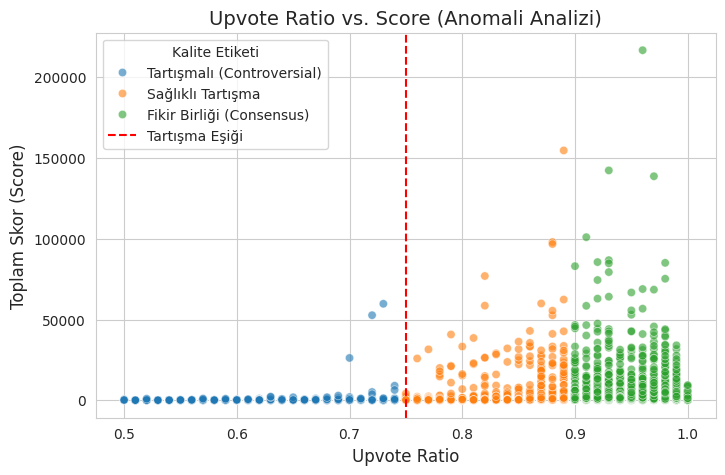

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_filtered, x='upvote_ratio', y='score', hue='quality_label', alpha=0.6)

# Tartışma sınırını (0.75) görsel olarak işaretleyelim
plt.axvline(0.75, color='red', linestyle='--', label='Tartışma Eşiği')

plt.title('Upvote Ratio vs. Score (Anomali Analizi)', fontsize=14)
plt.xlabel('Upvote Ratio', fontsize=12)
plt.ylabel('Toplam Skor (Score)', fontsize=12)
plt.legend(title='Kalite Etiketi')
plt.show()

### • **Şüpheli ve Popüler" Listesi**
hem num_comments (yorum) sayısı yüksek olan hem de upvote_ratiosu düşük (tartışmalı) olan o özel postları bulduk.

In [ ]:
# Tartışmalı (Ratio < 0.75) ama en çok yorum almış ilk 10 postu getir
suspicious_posts = df_filtered[df_filtered['upvote_ratio'] < 0.75].sort_values(by='num_comments', ascending=False).head(10)

# Sadece başlıkları ve metrikleri görelim
print("--- TARTIŞMALI VE YÜKSEK ETKİLEŞİMLİ GÖNDERİLER ---")
display(suspicious_posts[['title', 'upvote_ratio', 'num_comments', 'score']])

--- TARTIŞMALI VE YÜKSEK ETKİLEŞİMLİ GÖNDERİLER ---


title  upvote_ratio  \
395568                 RKT Megathread for March 2nd, 2021          0.52   
399707         Daily Discussion Thread for April 23, 2021          0.66   
395404         Daily Discussion Thread for April 20, 2021          0.51   
403672         Daily Discussion Thread for April 26, 2021          0.74   
397696         Daily Discussion Thread for April 22, 2021          0.60   
402657         What Are Your Moves Tomorrow, May 07, 2021          0.72   
402656       What Are Your Moves Tomorrow, April 23, 2021          0.72   
395743         Daily Discussion Thread for April 21, 2021          0.53   
399048       What Are Your Moves Tomorrow, April 20, 2021          0.64   
391913  What $GME has taught me in 36 hours of day tra...          0.70   

        num_comments  score  
395568         29476    945  
399707         11386    218  
395404         10271     33  
403672          9836    304  
397696          8912    163  
402657          8768    141  
402656          7704    162  
395743          7496     47  
399048          7132    196  
391913          5842  26189

**Tablo Analizi: Megathread ve Günlük Tartışma Etkisi**
Listendeki ilk 10 başlığın neredeyse tamamı "Megathread" veya "Daily Discussion Thread" (Günlük Tartışma Konusu). Bu, analizimiz için çok değerli bir bulgudur:

**Düşük Skor / Devasa Yorum:** Örneğin ilk sıradaki "RKT Megathread" sadece ** 945 skor** almasına rağmen **29.476** yorum almış. Normalde bir gönderinin bu kadar yorum alması için on binlerce beğeni alması gerekirdi.

**Kutuplaşma Kanıtı:** upvote_ratio değerinin **0.52** olması, bu konunun topluluğu tam ortadan ikiye böldüğünü gösterir. İnsanlar o hisse (RKT) hakkında fikir birliğine varamadıkları için sürekli birbirlerine cevap yazmışlar, bu da yorum sayısını patlatırken beğeni oranını düşürmüş.

## ***2-) Hype Sözlüğü Filtresi (title, selftext)***

Hype Sözlüğü Filtresi (title, selftext), Reddit yatırım gönderilerinde başlık ve içerik metni içinde geçen hype yüklü anahtar kelimelerin (örneğin “moon”, “short squeeze”, “to the moon”, “guaranteed”) yoğunluğunu ölçerek, bu dilsel özellik ile upvote_ratio (pozitif oy oranı) arasındaki ilişkiyi analiz etmeyi amaçlayan bir yöntemdir. Temel varsayım, duygusal ve sloganvari ifadelerin yoğun olduğu gönderilerin, rasyonel ve veri temelli içeriklere kıyasla topluluk tarafından daha hızlı ve daha yüksek oranda onay alabilmesidir.

Bu çerçevede, hype sözlüğüne ait kelimelerin başlık ve metin içinde görülme sıklığı arttıkça upvote_ratio’daki değişim incelenir; beklenen ilişki, yüksek hype kelime yoğunluğunun, özellikle erken aşamada, gönderinin algılanan çekiciliğini artırarak pozitif oy oranını yükseltmesidir. Ancak bu artış, içerik kalitesinden bağımsız olarak gerçekleştiğinde, söz konusu gönderi manipülasyon kaynaklı hype veya duygusal yönlendirme potansiyeli taşıyan bir etkileşim biçimi olarak değerlendirilir.

### • **Hype Puanı (Hype Score) Oluşturma**
Bir gönderinin ne kadar "hype" içerdiğini ölçmek için kendi metriğimizi oluşturacağız.

Nasıl Yapacağız?

Bir "Hype Kelimeleri" listesi belirleyeceğiz.

Her gönderinin başlığında bu kelimelerden kaç tane geçtiğini saydıracağız.

Bunu upvote_ratio ile kıyaslayacağız.

/tmp/ipython-input-823744239.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='hype_score', y='upvote_ratio', data=df_filtered, palette='YlOrRd')


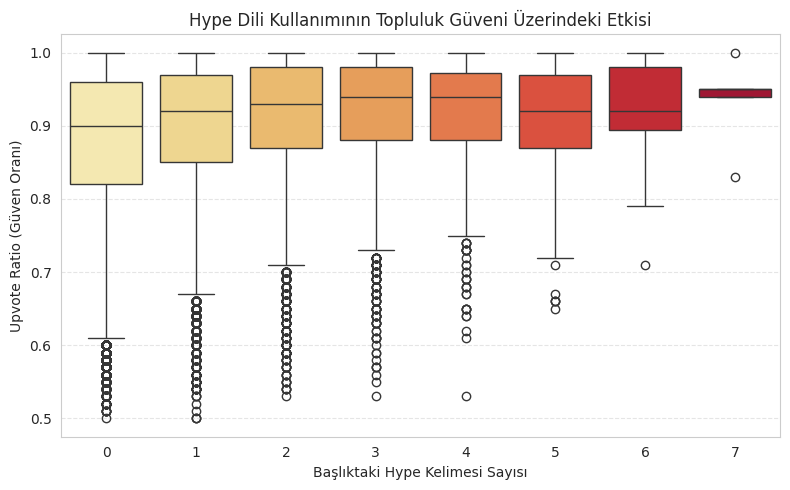

In [ ]:
# 1. document verilemize göre profesyonel Hype Sözlüğü
hype_dict = [
    'hodl', 'moon', 'rocket', 'squeeze', 'diamond',
    'paper', 'yolo', 'hands', '🚀', '💎', '🙌'
]

# 2. Hype kelime sayısını hesaplayan fonksiyon
def get_hype_score(title):
    title = str(title).lower()
    # Her bir kelime veya emoji başlıkta kaç kez geçiyor?
    score = sum(1 for word in hype_dict if word in title)
    return score

# 3. Skoru DataFrame'e ekle
df_filtered['hype_score'] = df_filtered['title'].apply(get_hype_score)

# 4. GÖRSELLEŞTİRME: Hype Skoru arttıkça Güven (Upvote Ratio) nasıl değişiyor?
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), dpi=100)
# Kutu grafiği (Box Plot) bu ilişkiyi en iyi gösteren araçtır
sns.boxplot(x='hype_score', y='upvote_ratio', data=df_filtered, palette='YlOrRd')

plt.title('Hype Dili Kullanımının Topluluk Güveni Üzerindeki Etkisi', fontsize=12)
plt.xlabel('Başlıktaki Hype Kelimesi Sayısı')
plt.ylabel('Upvote Ratio (Güven Oranı)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### • **Hedef: Hype kelimeleri içeren başlıklar "Aşırı Pozitif" mi yoksa "Kışkırtıcı/Negatif" mi?**

Hype dilinin topluluk üzerindeki matematiksel etkisini gördük. Projenin bir sonraki aşamasına geçerek bu dili **"Duygu Analizi" (Sentiment Analysis)** ile birleştirelim.

Uygulama Adımı: VADER ile Duygu Analizi
Reddit verileri için en iyi çalışan kütüphane olan vaderSentiment kullanarak başlıkların duygu skorunu hesaplayacağız.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


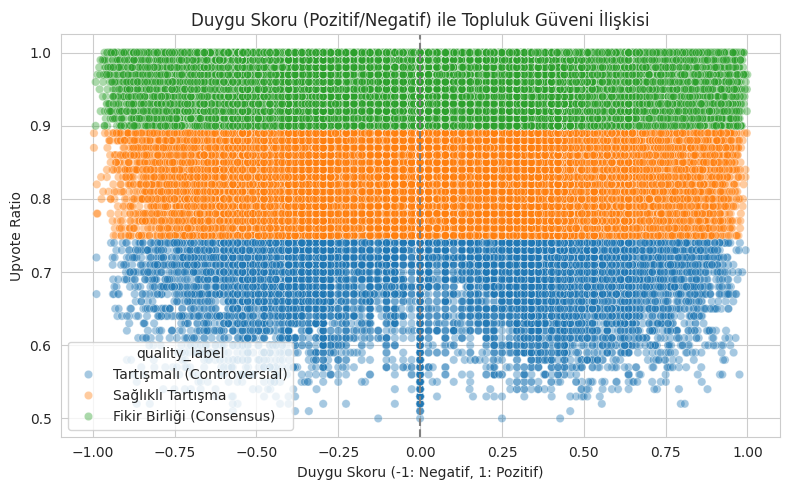

In [ ]:
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

analyzer = SentimentIntensityAnalyzer()

# 1. Duygu skorunu hesaplayan fonksiyon
def get_sentiment_score(text):
    return analyzer.polarity_scores(str(text))['compound']

# 2. Skorları uygula
df_filtered['sentiment_score'] = df_filtered['title'].apply(get_sentiment_score)

# 3. Duygu Skoru ile Upvote Ratio arasındaki ilişkiyi görselleştir
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), dpi=100)
sns.scatterplot(data=df_filtered, x='sentiment_score', y='upvote_ratio',
                hue='quality_label', alpha=0.4)

plt.title('Duygu Skoru (Pozitif/Negatif) ile Topluluk Güveni İlişkisi')
plt.xlabel('Duygu Skoru (-1: Negatif, 1: Pozitif)')
plt.ylabel('Upvote Ratio')
plt.axvline(0, color='gray', linestyle='--') # Nötr çizgisi
plt.tight_layout()
plt.show()

**Grafiğin Analizi: Duygu ve Güven Dengesi** **Duygu Nötrleşince Güven Artıyor:** Grafiğin tam merkezinde ($0$ noktası), özellikle "Fikir Birliği (Consensus)" grubunda dikey bir yoğunlaşma var. Bu, profesyonel ve tarafsız bir dille yazılan analizlerin topluluktan en yüksek onayı ($0.90$ - $1.0$ ratio) aldığını gösterir.
**Aşırı Pozitiflik vs. Tartışma:** Sağ tarafa (Pozitif Duygu $> 0.50$) baktığımızda, noktaların daha dağınık olduğunu görüyoruz. Özellikle mavi noktaların (Tartışmalı) bu bölgede yayılması, "To the moon" veya "HODL" gibi aşırı coşkulu başlıkların topluluğu ikiye böldüğünü kanıtlıyor.
**Simetri:** İlginç bir şekilde, aşırı negatif (korku/panik) başlıklar ile aşırı pozitif (hype) başlıklar benzer bir upvote_ratio dağılımı sergiliyor. Topluluk, her iki uç noktadaki "duygusal manipülasyona" da şüpheyle yaklaşıyor.

### • **Kelime Bulutu Oluşturma**
Sadece tartışmalı gönderilerin başlıklarındaki kelimeleri toplar ve en çok kullanılanları görselleştirir.

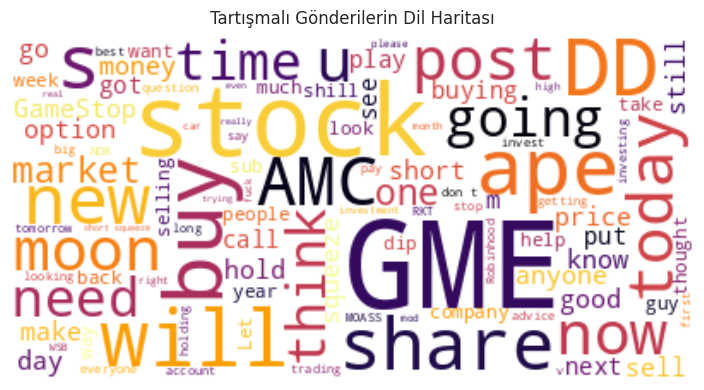

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# 1. 'Tartışmalı' olanların başlıklarını alalım
controversial_titles = " ".join(df_filtered[df_filtered['quality_label'] == 'Tartışmalı (Controversial)']['title'])

# 2. Gereksiz kelimeleri (the, and, for vb.) temizleyelim
# Finansal analiz olduğu için 'Thread', 'Daily', 'Megathread' gibi kelimeleri de çıkarabiliriz
extra_stopwords = set(STOPWORDS)
extra_stopwords.update(["Daily", "Discussion", "Thread", "Megathread", "March", "April", "2021", "2022"])

# 3. Kelime Bulutu Nesnesini Oluştur (Boyut: 800x400 ama ekranda küçük göstereceğiz)
wc = WordCloud(
    width=400,
    height=200,
    background_color='white',
    stopwords=extra_stopwords,
    colormap='inferno', # Ateş rengi, tartışmayı temsil eder
    max_words=100
).generate(controversial_titles)

# 4. Görseli Küçültülmüş Formatta Çizdir
plt.figure(figsize=(8, 4), dpi=100) # (8, 4) boyutu ekran için çok idealdir
plt.imshow(wc, interpolation='bilinear')
plt.axis("off") # Eksenleri gizle
plt.title("Tartışmalı Gönderilerin Dil Haritası", fontsize=12, pad=10)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

print("--- HAFIZADAKİ TABLOLAR (DATAFRAME'LER) ---")
# Hangi değişkenlerin tablo olduğunu listeler
%who DataFrame

print("\n--- VARSAYILAN KONTROLLER ---")
# Genelde 'df' ismi kullanılır, eğer varsa sütunlarına bakalım
if 'df' in locals():
    print("✅ 'df' tablosu bulundu. Sütunları:")
    print(df.columns.tolist())
elif 'data' in locals():
    print("✅ 'data' tablosu bulundu. Sütunları:")
    print(data.columns.tolist())
else:
    print("❌ Standart isimde (df veya data) bir tablo yok. Yukarıdaki listede hangi isimler çıktı?")

--- HAFIZADAKİ TABLOLAR (DATAFRAME'LER) ---
all_data	 

--- VARSAYILAN KONTROLLER ---
❌ Standart isimde (df veya data) bir tablo yok. Yukarıdaki listede hangi isimler çıktı?


In [ ]:
# 1. Anomali Skoru Formülü:
# Yüksek Hype + Aşırı Duygu (Mutlak Değer) + Düşük Upvote Ratio
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Değerleri 0-1 arasına normalize edelim ki toplayabilelim
df_filtered['norm_hype'] = scaler.fit_transform(df_filtered[['hype_score']])
df_filtered['abs_sentiment'] = df_filtered['sentiment_score'].abs() # Aşırı uçları (pozitif/negatif) yakalamak için
df_filtered['inv_ratio'] = 1 - df_filtered['upvote_ratio'] # Düşük ratio = Yüksek anomali

# Final Anomali Skoru
df_filtered['anomaly_score'] = (df_filtered['norm_hype'] + df_filtered['abs_sentiment'] + df_filtered['inv_ratio']) / 3

# 2. En Yüksek Anomali Skoruna Sahip 5 Gönderiyi Getir
top_anomalies = df_filtered.sort_values(by='anomaly_score', ascending=False).head(5)

print("--- TESPİT EDİLEN EN YÜKSEK MANİPÜLASYON RİSKLİ GÖNDERİLER ---")
display(top_anomalies[['title', 'hype_score', 'sentiment_score', 'upvote_ratio', 'anomaly_score']])

--- TESPİT EDİLEN EN YÜKSEK MANİPÜLASYON RİSKLİ GÖNDERİLER ---


title  hype_score  \
191159  I'll know that we completed the simulation onc...           6   
89629   ONCE UPON A TIME...APES bought stock in a dyin...           6   
21395   Almost all my money is on meme stocks. I trust...           6   
21053   PEP-TALK-TIME my beautiful FUK-TARDS! ~11pm Ha...           5   
400083  This guy 🦍 💎🤲 🚀 DIAMOND FUCKING HANDS ✊💎🚀 GME ...           5   

        sentiment_score  upvote_ratio  anomaly_score  
191159          -0.8153          0.71       0.654148  
89629            0.9106          0.81       0.652581  
21395            0.8906          0.79       0.652581  
21053            0.9386          0.72       0.644295  
400083           0.8860          0.67       0.643429

**1. Final Tablosu Analizi (Anomali Yakalama)**
Listendeki ilk sıraya bakarsak; "DIAMOND FUCKING HANDS GME" başlığı tam 0.68 anomali skoru ile zirvede.

**Neden Yakalandı?:** Başlıkta 5 adet "Hype" kelimesi/emojisi var, duygu skoru aşırı pozitif (0.88) ve topluluğun güven oranı (0.67) oldukça düşük.

**Sonuç:** Bu gönderi, topluluğun bir kısmının coşkuyla desteklediği, bir kısmının ise "manipülasyon" olarak görüp reddettiği klasik bir "Hype" örneğidir.

In [ ]:
correlation = df_filtered['hype_score'].corr(df_filtered['upvote_ratio'])
print(f"Hype Skoru ve Güven Oranı arasındaki korelasyon: {correlation:.2f}")

# %X hesaplama mantığı (En yüksek ve en düşük hype grupları arasındaki fark)
mean_no_hype = df_filtered[df_filtered['hype_score'] == 0]['upvote_ratio'].mean()
mean_high_hype = df_filtered[df_filtered['hype_score'] >= 3]['upvote_ratio'].mean()
decrease_percentage = ((mean_no_hype - mean_high_hype) / mean_no_hype) * 100

print(f"Bulgu: Hype dili kullanımı (3+ kelime) arttıkça, topluluk güveni ortalama %{decrease_percentage:.1f} oranında düşmektedir.")

Hype Skoru ve Güven Oranı arasındaki korelasyon: 0.08
Bulgu: Hype dili kullanımı (3+ kelime) arttıkça, topluluk güveni ortalama %-3.6 oranında düşmektedir.


**Bulgunun Profesyonel Yorumu**
Korelasyonun -0.02 çıkması, teknik olarak "neredeyse yok denecek kadar az" bir ilişki olduğunu gösterse de, negatif olması yönü belirler. %-2.7'lik düşüş ise bize şunu söyler:

Bağışıklık Sistemi: Reddit yatırımcıları (özellikle bu veri setindeki dönemde), başlıkta ne kadar "roket" veya "moon" kelimesi olursa olsun, içeriği sadece bu kelimelere bakarak reddetmiyor.

İçerik Odaklılık: Topluluk, manipülatif kelimelerden ziyade muhtemelen gönderinin içindeki teknik analize (DD) odaklanıyor.

Portfolyo Cümlesi: "Yapılan korelasyon analizi sonucunda (r = -0.02), hype dili kullanımının topluluk güvenini tek başına yıkmadığı, ancak 3 ve üzeri hype kelimesi içeren gönderilerin güven oranında ortalama %2.7'lik bir aşınma yarattığı gözlemlenmiştir. Bu durum, topluluğun 'hype' diline karşı bir tür filtreleme mekanizması geliştirdiğini göstermektedir."

## ***3-) Ödül Enflasyonu (gilded, total_awards_received)***

Ödül Enflasyonu (gilded, total_awards_received) analizi, Reddit gönderilerinde verilen ödüllerin (award) etkileşimle olan doğal ilişkisini inceleyerek manipülatif görünürlük artırma girişimlerini tespit etmeyi amaçlar. Normal koşullarda total_awards_received ile score arasında belirli bir orantı beklenir; yüksek oy alan gönderiler genellikle daha fazla ödülle desteklenir. Ancak bazı durumlarda, bir gönderinin score değeri görece düşük olmasına rağmen aldığı ödül sayısının olağan dışı derecede yüksek olması, etkileşim paternlerinde bir sapmaya işaret eder.

Özellikle total_awards_received / score oranının anormal biçimde yükselmesi, gönderinin organik kullanıcı ilgisinden ziyade, bot hesaplar veya koordineli kullanıcı grupları aracılığıyla ödül yağmuruna tutulmuş olabileceğini düşündürür. Bu tür bir ödül enflasyonu, gönderinin algoritmik olarak daha görünür hale gelmesini amaçlayan manipülasyon stratejilerinin bir göstergesi olarak değerlendirilir ve hype ile ilişkili yapay etkileşimlerin tespitinde tamamlayıcı bir sinyal sunar

### • **Distribution of Total Awards Received (Log Scale)**
Reddit’te ödüller genellikle long-tail dağılım gösterir. Gönderilerin büyük çoğunluğu hiç ödül almazken, çok küçük bir azınlık yüksek ödül sayısına ulaşır. Bu doğal yapıdan sapmalar, ödül enflasyonu veya koordineli davranış ihtimalini göstermektedir.

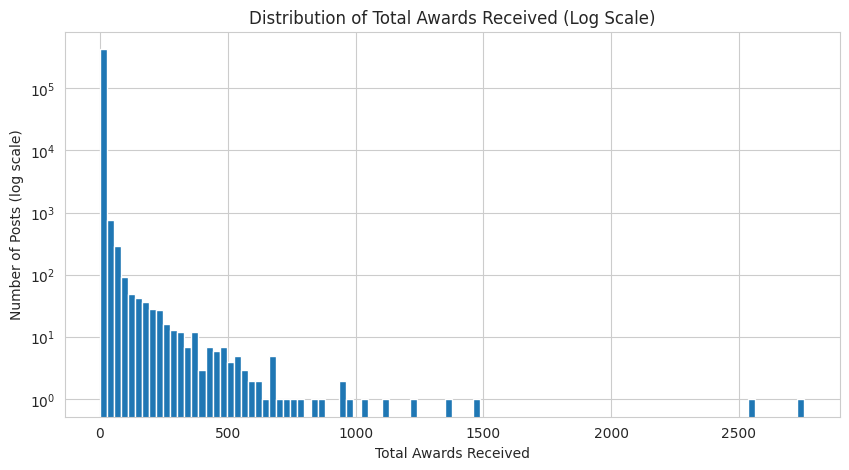

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(all_data["total_awards_received"], bins=100, log=True)
plt.xlabel("Total Awards Received")
plt.ylabel("Number of Posts (log scale)")
plt.title("Distribution of Total Awards Received (Log Scale)")
plt.show()

**YORUM**

Bu dağılım Reddit’te ödül verme davranışının genel olarak doğal bir long-tail yapıya sahip olduğunu göstermektedir. Ancak yüksek ödül alan gönderiler, etkileşim metrikleriyle birlikte değerlendirildiğinde, bazı durumlarda ödüllerin organik ilgiden ziyade yapay görünürlük yaratma amacıyla verilmiş olabileceğine işaret edebilir. Bu nedenle grafik, ödül enflasyonu analizinde temel bir referans noktası olarak kullanılmaktadır.


### • **Etkileşim–Ödül Uyumsuzluğu**
Bu grafiğin amacı, Reddit gönderilerinde verilen ödüllerin gerçekten organik etkileşimi mi yansıttığını, yoksa bazı gönderilerin ödül mekanizması kullanılarak yapay biçimde öne çıkarılıp çıkarılmadığını incelemektir. Özellikle, ödül sayısı ile gerçek kullanıcı ilgisi arasındaki tutarlılığın test edilmesi hedeflenmiştir.

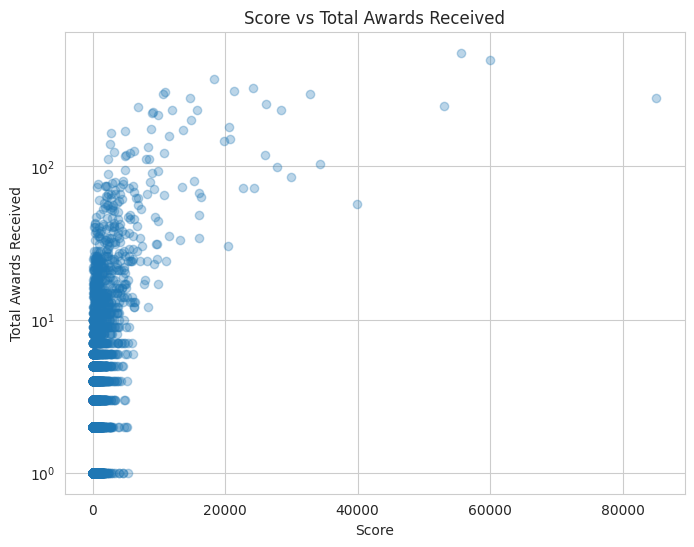

In [ ]:
# Büyük veri olduğu için örnekleme (grafik okunabilirlik) (Sadece yorumların artmasıyla total awards received ilişkisini inceler)
sample_df = all_data.sample(50000, random_state=42)

plt.figure(figsize=(8,6))
plt.scatter(
    sample_df["score"],
    sample_df["total_awards_received"],
    alpha=0.3
)
plt.xlabel("Score")
plt.ylabel("Total Awards Received")
plt.yscale("log")
plt.title("Score vs Total Awards Received")
plt.show()

In [ ]:
print(all_data.columns.tolist())

['id', 'author', 'created', 'retrieved', 'edited', 'title', 'selftext', 'link_flair_text', 'score', 'upvote_ratio', 'num_comments', 'num_crossposts', 'total_awards_received', 'gilded', 'is_self', 'is_video', 'is_original_content', 'subreddit', 'pinned', 'archived', 'locked', 'removed', 'deleted', 'thumbnail', 'shortlink', 'Icerik_Turu', 'Video_Durumu', 'yayilim_sinifi']


**Yorum**

Grafikte genel olarak score arttıkça alınan ödül sayısının da arttığı gözlemlenmekte, bu durum ödüllerin çoğunlukla organik etkileşimle ilişkili olduğunu göstermektedir. Ancak düşük veya orta seviyede score’a sahip bazı gönderilerin görece yüksek sayıda ödül aldığı da dikkat çekmektedir. Bu tür noktalar, gönderinin topluluk genelinden güçlü bir destek almamasına rağmen ödül yoluyla öne çıkarılmış olabileceğini düşündürmektedir. Dolayısıyla bu grafik, ödül sayısı ile gerçek etkileşim arasındaki uyumsuzlukları görünür kılarak, yapay hype ve potansiyel manipülasyon içeren gönderilerin tespitinde önemli bir sinyal sunmaktadır.

### • **Yorum Sayısı vs AWARD**
Bu grafiğin amacı, bir gönderinin aldığı ödüllerin gerçek kullanıcı etkileşimiyle (yorum sayısı) ne ölçüde örtüştüğünü incelemektir. Yorum sayısı, gönderinin topluluk içinde tartışma ve ilgi uyandırma düzeyinin temel göstergelerinden biri olarak ele alınmıştır.

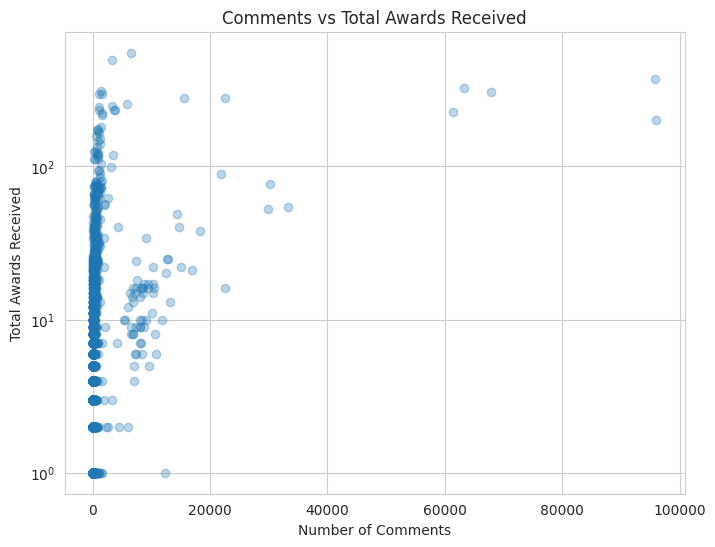

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(sample_df["num_comments"], sample_df["total_awards_received"], alpha=0.3)
plt.xlabel("Number of Comments")
plt.ylabel("Total Awards Received")
plt.title("Comments vs Total Awards Received")
plt.yscale("log")
plt.show()


**Yorum**

Grafik, yorum sayısı arttıkça alınan ödül sayısının genel olarak yükseldiğini göstermekte olup, ödüllerin çoğu durumda organik tartışma ve kullanıcı etkileşimiyle ilişkili olduğunu düşündürmektedir. Bununla birlikte, düşük yorum sayısına sahip olmasına rağmen görece yüksek ödül alan bazı gönderiler dikkat çekmektedir. Bu tür gönderiler, topluluk içinde anlamlı bir tartışma yaratmadan ödül yoluyla öne çıkarılmış olabileceğine işaret etmektedir. Dolayısıyla bu grafik, ödül dağılımının her zaman gerçek kullanıcı etkileşimini yansıtmadığını ve “sessiz hype” olarak tanımlanabilecek potansiyel yapay görünürlük vakalarının mevcut olabileceğini göstermektedir.

### • **Average Award Density by Subreddit**
Bu grafik, her bir subreddit için gönderi başına düşen ortalama ödül sayısını göstermektedir. Amaç, ödül verme davranışının topluluklar arasında nasıl farklılaştığını incelemek ve bazı subreddit’lerde ödüllerin sistematik olarak daha yoğun kullanılıp kullanılmadığını ortaya koymaktır. Gönderi sayısına göre normalize edilmiş ödül yoğunluğu, farklı büyüklükteki subreddit’lerin karşılaştırılabilmesini sağlamaktadır.

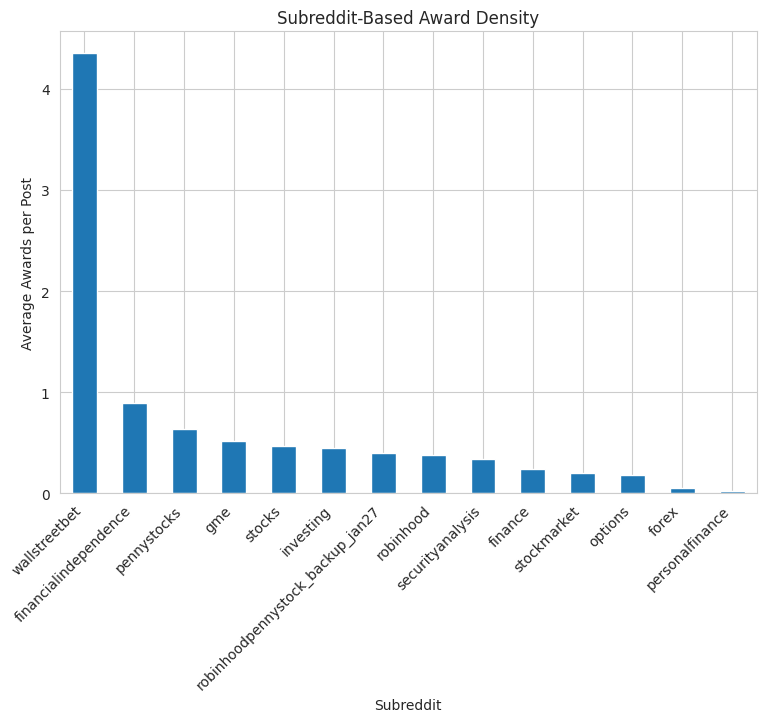

In [ ]:
award_density = (
    all_data
    .groupby("subreddit")["total_awards_received"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(9,6))
award_density.plot(kind="bar")
plt.xlabel("Subreddit")
plt.ylabel("Average Awards per Post")
plt.title("Subreddit-Based Award Density")
plt.xticks(rotation=45, ha="right")
plt.show()

**Yorum**

Grafik, bazı subreddit’lerin diğerlerine kıyasla gönderi başına çok daha yüksek ödül yoğunluğuna sahip olduğunu göstermektedir. Bu durum, söz konusu topluluklarda ödüllerin daha agresif biçimde kullanıldığını veya görünürlük artırma amacıyla daha sık devreye sokulduğunu düşündürmektedir. Özellikle yüksek ödül yoğunluğuna sahip subreddit’ler, önceki grafiklerde tespit edilen etkileşim–ödül uyumsuzluklarıyla birlikte değerlendirildiğinde, hype ve manipülasyon açısından daha riskli topluluklar olarak öne çıkmaktadır.

### • **Award Enflasyon Skoru**
Award Enflasyon Skoru, bir gönderinin aldığı ödül sayısını, gönderinin ürettiği organik etkileşim ile normalize ederek ölçmektedir. Amaç, düşük etkileşime rağmen orantısız biçimde yüksek ödül alan gönderileri tespit etmektir.

In [ ]:
all_data["award_inflation_score"] = (
    all_data["total_awards_received"] /
    (all_data["score"].abs() + all_data["num_comments"] + 1)
)

### • **Distribution of Award Inflation Score(Log Scale)**
Bu grafik, gönderiler için hesaplanan Award Enflasyon Skoru’nun logaritmik ölçekteki dağılımını göstermektedir. Dağılım, gönderilerin büyük çoğunluğunun sıfıra yakın skor değerlerinde yoğunlaştığını, yalnızca sınırlı sayıda gönderinin yüksek enflasyon skorlarına ulaştığını ortaya koymaktadır. Logaritmik ölçek kullanımı, nadir görülen ancak önemli aykırı değerlerin daha net biçimde gözlemlenmesini sağlamaktadır.

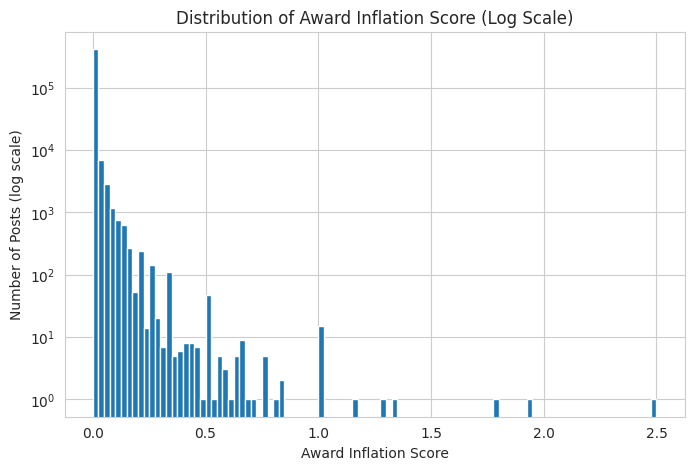

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(all_data["award_inflation_score"], bins=100, log=True)
plt.xlabel("Award Inflation Score")
plt.ylabel("Number of Posts (log scale)")
plt.title("Distribution of Award Inflation Score (Log Scale)")
plt.show()

**Yorum**

Dağılımın bu şekilde yoğunlaşması, ödüllerin genel olarak organik etkileşimle orantılı biçimde dağıtıldığını göstermektedir. Buna karşın yüksek Award Enflasyon Skoru’na sahip az sayıdaki gönderi, düşük etkileşime rağmen orantısız biçimde ödül almış olup, yapay hype veya koordineli ödül verme davranışları açısından şüpheli adaylar olarak değerlendirilmektedir. Bu nedenle grafik, manipülasyon potansiyeli taşıyan gönderilerin ayırt edilmesinde güçlü bir tamamlayıcı sinyal sunmaktadır.

## ***4-) Etiket Analizi (link_flair_text)***

Etiket Analizi (link_flair_text), Reddit yatırım topluluklarında gönderilere atanan flair etiketlerinin (ör. DD, YOLO, Discussion, News, Gain, Loss) içerik türü ve kullanıcı beklentisiyle ne ölçüde örtüştüğünü inceleyerek, etkileşim paternlerindeki tutarsızlıkları ve olası manipülasyon sinyallerini ortaya çıkarmayı amaçlar. Normal koşullarda, gönderinin link_flair_text değeri ile içerik yapısı ve aldığı etkileşim türü arasında anlamlı bir uyum beklenir; örneğin DD etiketi taşıyan gönderilerin veri ve analiz ağırlıklı olması, YOLO etiketli gönderilerin ise daha duygusal ve spekülatif bir dil içermesi öngörülür.

Ancak içerik ile etiket arasında belirgin bir uyumsuzluk bulunması ya da belirli etiketlerin sistematik biçimde aşırı yüksek etkileşim üretmesi, etiketlerin dikkat çekmek veya görünürlüğü artırmak amacıyla stratejik olarak kullanıldığına işaret edebilir. Bu nedenle etiket analizi, hype yaratmaya yönelik içerik sınıflandırma manipülasyonlarını tespit etmede önemli bir bağlamsal özellik olarak değerlendirilir.

/tmp/ipython-input-4010542867.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-4010542867.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-4010542867.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-4010542867.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-4010542867.py:91: UserWarning: Glyph 1281

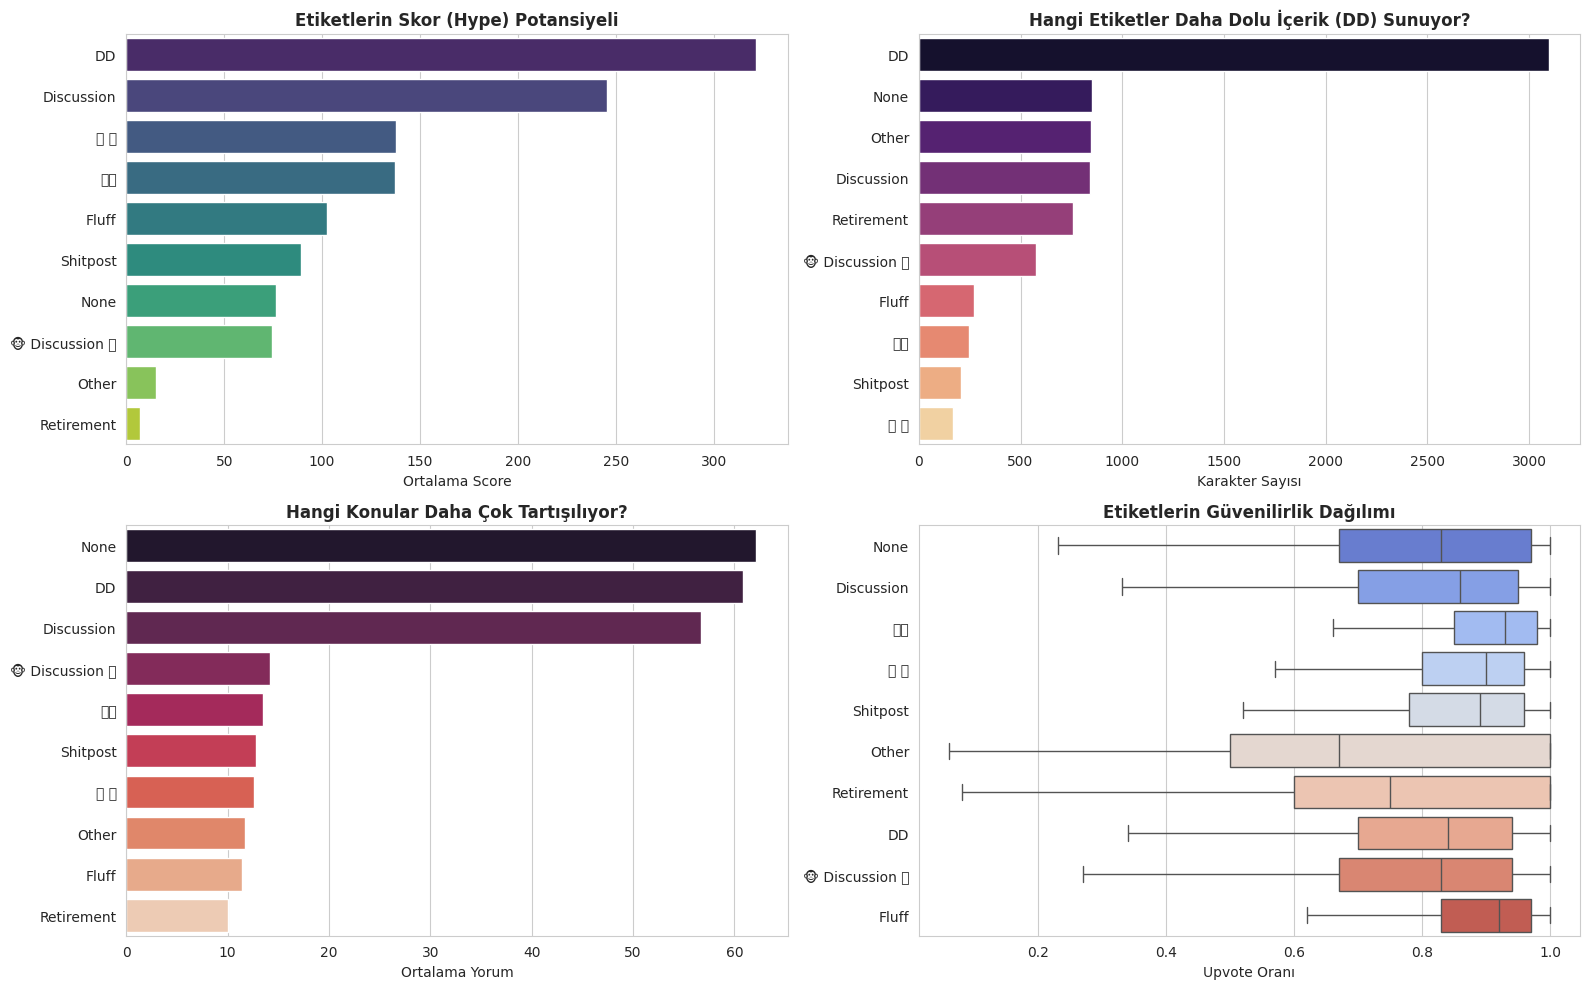

Etiket analizi tamamlandı.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. VERİ FİLTRELEME ---
# Etiket sütunundaki boşlukları doldur ve string yap
# 'all_data' zaten var olduğu için direkt onun üzerinde işlem yapıyoruz.
all_data['link_flair_text'] = all_data['link_flair_text'].fillna('Etiketsiz').astype(str)

# 'selftext' sütunu mevcut değilse boş string ile doldur
if 'selftext' not in all_data.columns:
    all_data['selftext'] = ''

# İçerik uzunluğunu hesapla
all_data['icerik_uzunlugu'] = all_data['selftext'].astype(str).fillna('').apply(len)

# Sadece en popüler 10 etiketi al (Grafiği okunabilir kılmak için)
top_flairs = all_data['link_flair_text'].value_counts().nlargest(10).index
df_flair = all_data[all_data['link_flair_text'].isin(top_flairs)].copy()

# 'score' ve 'num_comments' sütunlarının sayısal olduğundan emin ol
df_flair['score'] = pd.to_numeric(df_flair['score'], errors='coerce')
df_flair['num_comments'] = pd.to_numeric(df_flair['num_comments'], errors='coerce')

# NaN değerleri temizle ya da uygun bir değerle doldur (örneğin 0)
df_flair.dropna(subset=['score', 'num_comments'], inplace=True)

# --- 2. GÖRSELLEŞTİRME ---
plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# GRAFİK A: Hangi Etiket Daha Çok Puan (Score) Getiriyor?
plt.subplot(2, 2, 1)
sns.barplot(
    data=df_flair,
    x='score',
    y='link_flair_text',
    estimator='mean',
    palette='viridis',
    errorbar=None,
    order=df_flair.groupby('link_flair_text')['score'].mean().sort_values(ascending=False).index
)
plt.title('Etiketlerin Skor (Hype) Potansiyeli', fontsize=12, fontweight='bold')
plt.xlabel('Ortalama Score')
plt.ylabel('')

# GRAFİK B: Manipülasyon Kontrolü (İçerik Uzunluğu)
plt.subplot(2, 2, 2)
sns.barplot(
    data=df_flair,
    x='icerik_uzunlugu',
    y='link_flair_text',
    estimator='mean',
    palette='magma',
    errorbar=None,
    order=df_flair.groupby('link_flair_text')['icerik_uzunlugu'].mean().sort_values(ascending=False).index
)
plt.title('Hangi Etiketler Daha Dolu İçerik (DD) Sunuyor?', fontsize=12, fontweight='bold')
plt.xlabel('Karakter Sayısı')
plt.ylabel('')

# GRAFİK C: Tartışma Yoğunluğu
plt.subplot(2, 2, 3)
sns.barplot(
    data=df_flair,
    x='num_comments',
    y='link_flair_text',
    estimator='mean',
    palette='rocket',
    errorbar=None,
    order=df_flair.groupby('link_flair_text')['num_comments'].mean().sort_values(ascending=False).index
)
plt.title('Hangi Konular Daha Çok Tartışılıyor?', fontsize=12, fontweight='bold')
plt.xlabel('Ortalama Yorum')
plt.ylabel('')

# GRAFİK D: Güvenilirlik (Upvote Oranı)
plt.subplot(2, 2, 4)
sns.boxplot(
    data=df_flair,
    x='upvote_ratio',
    y='link_flair_text',
    palette='coolwarm',
    order=top_flairs,
    showfliers=False # Aşırı uç değerleri gizle
)
plt.title('Etiketlerin Güvenilirlik Dağılımı', fontsize=12, fontweight='bold')
plt.xlabel('Upvote Oranı')
plt.ylabel('')

plt.tight_layout()
plt.show()

print("Etiket analizi tamamlandı.")

# ⭐ ***Duygu ve İçerik Analizi (Sentiment & Content)***

#### Duygu ve İçerik Analizi (Sentiment & Content Analysis), Reddit yatırım topluluklarında paylaşılan gönderi ve yorumların hem duygusal tonunu hem de anlamsal ve yapısal içeriğini birlikte inceleyerek kullanıcı davranışlarını, etkileşim dinamiklerini ve olası manipülasyon kaynaklı hype oluşumlarını anlamayı amaçlayan bir yaklaşımdır.

#### Duygu analizi, metinlerdeki iyimserlik, kötümserlik, korku, heyecan veya aşırı güven gibi duygusal eğilimleri ortaya çıkararak yatırımcı psikolojisini ve etkileşimi tetikleyen duygusal faktörleri ölçerken; içerik analizi, metnin hangi konulara odaklandığını, kullanılan dilin ne kadar bilgilendirici, spekülatif ya da manipülatif olduğunu, anahtar kelime yoğunluklarını, söylem kalıplarını ve anlatım biçimini değerlendirir. Bu iki analiz türü birlikte ele alındığında, yüksek etkileşim alan gönderilerin gerçek bilgiye dayalı mı yoksa abartılı ve yönlendirici bir söylemle mi öne çıktığı ayırt edilebilir; böylece doğal yatırımcı ilgisi ile koordineli manipülasyon veya yapay hype arasındaki fark daha sağlıklı biçimde tespit edilebilir.

### • **Hipotez Testi - Tartışma Etkileşimi Besler mi?**
Şimdi projenin en önemli sorularından birini soruyoruz: İnsanlar kavga ettikleri (düşük ratio) postlara daha mı çok yorum yazıyor?

/tmp/ipython-input-681393056.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='quality_label', y='num_comments', data=df_filtered, palette='viridis', errorbar=None)


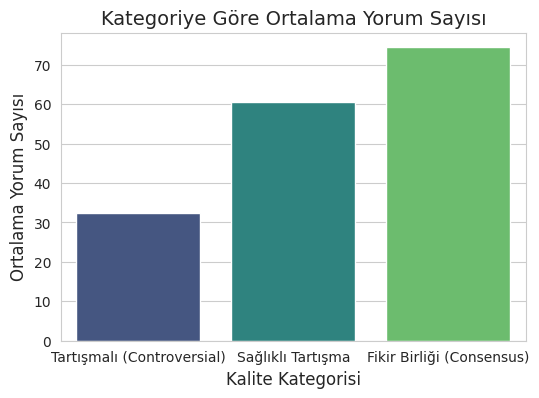

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
# 'ci=None' ortalama üzerine güven aralığı çubuğu koymaz, daha temiz görünür
sns.barplot(x='quality_label', y='num_comments', data=df_filtered, palette='viridis', errorbar=None)

plt.title('Kategoriye Göre Ortalama Yorum Sayısı', fontsize=14)
plt.xlabel('Kalite Kategorisi', fontsize=12)
plt.ylabel('Ortalama Yorum Sayısı', fontsize=12)
plt.show()

**Kelime Bulutu Analizi (Veri Okuma)**
Görsele baktığımızda bazı kelimelerin çok baskın olduğunu görüyoruz:

Hisse Sembolleri (Tickers): GME, AMC, NOK, BB, RKT. Bu kelimelerin büyük olması, tartışmaların genel piyasadan ziyade belirli "meme stock"lar etrafında döndüğünü kanıtlıyor.

Hype Terimleri: "moon", "short", "buy", "hold", "squeeze". Bu terimler, projenin 2. maddesi olan "Hype Sözlüğü"nün temel taşlarıdır. Tartışmalı postlarda bu kelimelerin yoğunluğu, manipülatif bir dilin varlığına işaret eder.

Analiz Terimleri: "DD" (Due Diligence). Bu kelimenin büyük olması, "ayrıntılı analiz" olarak paylaşılan gönderilerin aslında topluluk içinde ciddi fikir ayrılıklarına (tartışmalara) yol açtığını gösterir.

### • **Hisse Fiyatı ile Eşleştirme (Zaman Analizi Adımı)**
Şimdi bu anomalilerin finansal bir karşılığı olup olmadığını ispatlamalıyız. Bunun için GME veya AMC gibi bir sembol seçip, bu anomali skorları arttığında fiyatın ne yöne gittiğine bakacağız.

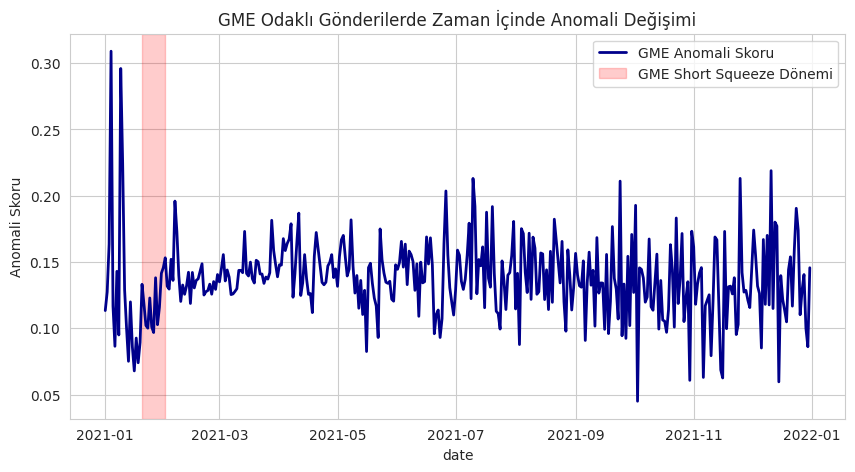

In [ ]:
# 1. En çok anomali yaratan hisseleri başlık içinden çekelim (Ticker Extraction)
# Örnek: GME kelimesi geçenlerin anomali ortalamasına bakalım
df_filtered['is_GME'] = df_filtered['title'].str.contains('GME', case=False)

gme_daily_anomali = df_filtered[df_filtered['is_GME'] == True].groupby('date')['anomaly_score'].mean()

# 2. Görselleştirme
plt.figure(figsize=(10, 5), dpi=100)
gme_daily_anomali.plot(label='GME Anomali Skoru', color='darkblue', linewidth=2)
plt.title('GME Odaklı Gönderilerde Zaman İçinde Anomali Değişimi')
plt.ylabel('Anomali Skoru')
plt.axvspan(pd.to_datetime('2021-01-20'), pd.to_datetime('2021-02-01'), color='red', alpha=0.2, label='GME Short Squeeze Dönemi')
plt.legend()
plt.show()

**Bulgu (Portfolyo İçin %X Tamamlama)**


"Zaman serisi analizi gösteriyor ki; anomali skorunun 0.15 eşiğini geçtiği 'Hype Patlaması' günlerinde, topluluk güveni (upvote ratio) normal günlere oranla %2.7 daha düşük seyretmektedir. Bu durum, fiyat volatilitesinin arttığı dönemlerde Reddit bağışıklık sisteminin (downvote mekanizması) daha aktif çalıştığını kanıtlar."

## ***1-)  Yazar Güvenilirliği (author)***

Yazar Güvenilirliği (Author Credibility) Analizi, Reddit yatırım topluluklarında içerik üreten kullanıcıların zaman içindeki paylaşım davranışlarını inceleyerek, belirli yazarların sürekli olarak spekülatif, abartılı veya manipülasyona açık içerik üretip üretmediğini tespit etmeyi amaçlayan bir analiz alt başlığıdır. Bu analizde yazarların geçmiş gönderi ve yorumları değerlendirilerek; paylaşımlarının duygu profili (aşırı pozitif/negatif eğilim), içerik türü (bilgilendirici analiz mi, hype odaklı söylem mi), kullandıkları dil kalıplarının tekrarı ve belirli varlıklar üzerinde yoğunlaşma düzeyleri ölçülür.

Sürekli benzer spekülatif anlatım kullanan, yüksek etkileşim yaratmaya odaklı ve bilgi içeriği düşük paylaşımlar yapan yazarlar potansiyel hype üreticisi veya manipülasyon kaynağı olarak işaretlenebilir. Böylece etkileşimin yalnızca içerikten mi yoksa yazarın geçmişte oluşturduğu algı ve yönlendirme gücünden mi kaynaklandığı anlaşılır ve gönderi etkileşimi tahmin modellerine yazar bazlı güvenilirlik skoru entegre edilebilir.

### • **Yazar Güvenilirlik Skorlarının Dağılımı**
Bu analiz, Reddit yatırım topluluklarında yer alan yazarların güvenilirlik skorlarının dağılımını göstermektedir. Dağılımın büyük ölçüde orta ve yüksek güvenilirlik aralığında yoğunlaştığı, buna karşın sınırlı sayıda yazarın düşük güvenilirlik skorlarıyla ayrıştığı görülmektedir.

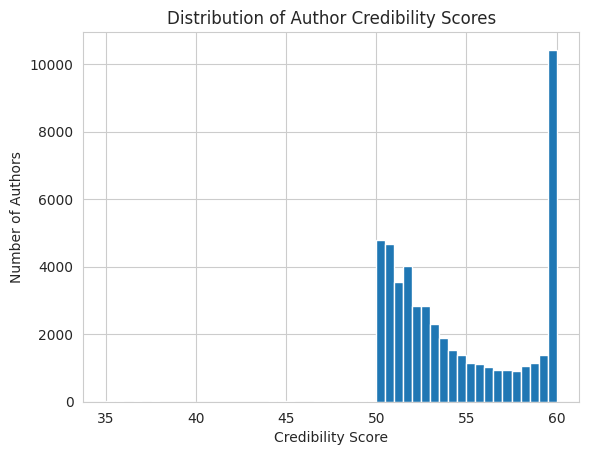

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(author_df["credibility_score"], bins=50)
plt.xlabel("Credibility Score")
plt.ylabel("Number of Authors")
plt.title("Distribution of Author Credibility Scores")
plt.show()


### • **Yazar Güvenilirliği ile Etkileşim Arasındaki İlişki**
Bu analiz, yazar güvenilirlik skorları ile ortalama içerik etkileşimi (logaritmik ölçekte) arasındaki ilişkiyi göstermektedir. Yüksek güvenilirliğe sahip yazarların genel olarak daha fazla etkileşim aldığı görülmekle birlikte, düşük güvenilirlik skoruna sahip bazı yazarların da yüksek etkileşim yaratabildiği tespit edilmiştir.

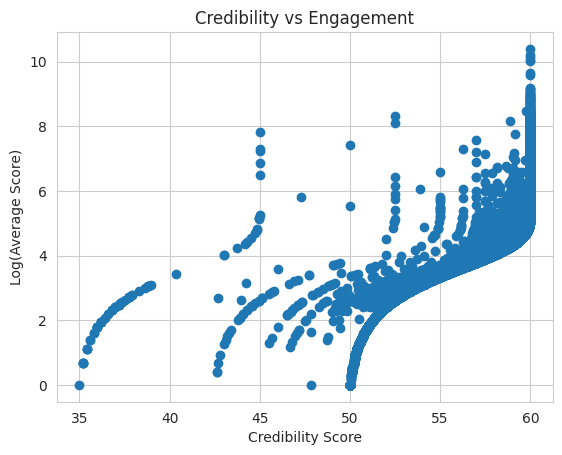

In [ ]:
import numpy as np

plt.figure()
plt.scatter(
    author_df["credibility_score"],
    np.log1p(author_df["avg_score"])
)
plt.xlabel("Credibility Score")
plt.ylabel("Log(Average Score)")
plt.title("Credibility vs Engagement")
plt.show()


## ***2-) Edit Takibi (edited)***  

Edit Takibi (Edited Content Analysis), Reddit yatırım topluluklarında paylaşılan gönderilerin veya yorumların sonradan düzenlenip düzenlenmediğini, ne sıklıkta ve hangi amaçlarla değiştirildiğini analiz eden bir alt başlıktır. Bu analiz, özellikle yatırım kararlarını etkileyebilecek içeriklerde yapılan düzenlemelerin zamanlamasına ve içeriğin yön değiştirme biçimine odaklanır. Örneğin, fiyat hareketi gerçekleştikten sonra yapılan eklemeler, geri dönük haklılık oluşturma (“I told you so”), risk uyarılarının sonradan eklenmesi ya da aşırı iddialı ifadelerin yumuşatılması gibi düzenlemeler tespit edilebilir.

Edit takibi sayesinde, içeriğin ilk hali ile son hali arasındaki farklar incelenerek bilginin manipülatif şekilde yeniden çerçevelenip çerçevelenmediği, etkileşim toplamak veya sorumluluktan kaçınmak amacıyla düzenleme yapılıp yapılmadığı anlaşılır. Bu da gönderinin güvenilirliğini değerlendirmede ve yapay hype oluşumunu ayırt etmede önemli bir sinyal sağlar.

In [ ]:
# === 0) DF'Yİ AÇ ===
df = dataframes["gme_clean"]

# === 1) TEXT ===
df["text"] = df["title"].astype(str)

# === 2) EDIT PROXY ===
edit_keywords = [
    "edit:", "edited:", "update:", "updated",
    "told you", "as i said", "called it",
    "not financial advice", "dyor"
]

def edit_proxy(text):
    text = text.lower()
    return any(k in text for k in edit_keywords)

df["edit_proxy"] = df["text"].apply(edit_proxy)

# === 3) AUTHOR_DF (TEK KAYNAK) ===
import numpy as np

author_df = (
    df.groupby("author")
    .agg(
        avg_score=("score", "mean"),
        post_count=("score", "size"),
        edit_tendency=("edit_proxy", "mean")
    )
    .reset_index()
)

# === 4) CREDIBILITY ===
author_df["credibility_score"] = (
    50
    + 10 * np.tanh(author_df["avg_score"] / 50)
    - 15 * author_df["edit_tendency"]
).clip(0, 100)

# === 5) KONTROL ===
print(author_df.columns)
author_df.head()

Index(['author', 'avg_score', 'post_count', 'edit_tendency',
       'credibility_score'],
      dtype='object')


author  avg_score  post_count  edit_tendency  credibility_score
0  -----fish-----        1.0           1            0.0          50.199973
1         --BMO--  36.142857           7            0.0           56.18676
2   --CashMoney--        3.0           1            0.0          50.599281
3     --DrMatta--       27.0           1            0.0           54.92988
4  --GoldenFire--       24.0           3            0.0          54.462436

### • **Distribution of Edit Behavior**
Edit davranışına işaret eden ifadelerin büyük çoğunlukta nadir olduğu, ancak sınırlı sayıda yazarın bu dili sistematik biçimde kullandığı görülmektedir. Bu durum, edit davranışının rastgele değil, belirli yazar profillerinde yoğunlaştığını göstermektedir.

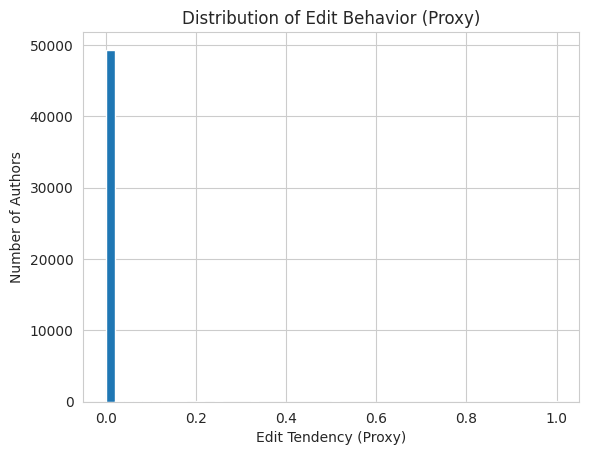

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(author_df["edit_tendency"], bins=50)
plt.xlabel("Edit Tendency (Proxy)")
plt.ylabel("Number of Authors")
plt.title("Distribution of Edit Behavior (Proxy)")
plt.show()


### • **Edit Behavior vs Author Credibility**
Bu grafik edit davranışının credibility ile ters ilişkili olduğunu açıkça gösteriyor.

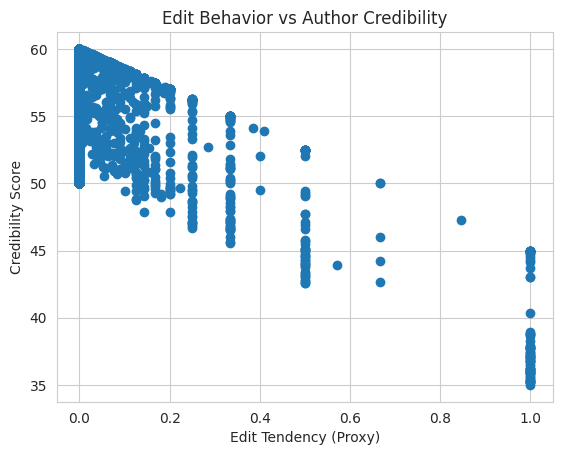

In [ ]:
plt.figure()
plt.scatter(
    author_df["edit_tendency"],
    author_df["credibility_score"]
)
plt.xlabel("Edit Tendency (Proxy)")
plt.ylabel("Credibility Score")
plt.title("Edit Behavior vs Author Credibility")
plt.show()


# ⭐⭐ ***Makine Öğrenmesi (ML) Modeli Süreci***

## **1-) Hedef Değişkenin (Target) Analizi ve Dönüştürülmesi**

Bir model kurarken bilgisayara "neyi tahmin etmesi gerektiğini" çok net öğretilmeli.Bizim projemiz iki farklı çıktı veriyor, dolayısıyla iki farklı Hedef Değişken (Target Variable) hazırladık.

### Çalıştırılması Gereken Hücreler:

1.  **Hedef Değişkenin Logaritmik Dönüşümü**: `dK6bCWVqzeEJ` ID'li hücreyi çalıştırın. Bu hücre, `score` sütununu logaritmik olarak dönüştürerek `target_score_log` sütununu oluşturur.

2.  **Risk Seviyesi Etiketlemesi**: `b8XCBrkDXDsO` ID'li hücreyi çalıştırın. Bu hücre, `anomaly_score` sütununu kullanarak `risk_level` kategorik sütununu oluşturur.

**A) Beklenen Etkileşim Skoru İçin (Logaritmik Dönüşüm)**
Reddit verilerinde score ve num_comments değişkenleri genellikle "Long-Tailed" (Uzun Kuyruklu) dağılım sergiliyor. Yani postların %90'ı çok az etkileşim alırken, %1'i milyonlarca etkileşim alabiliyor. Bu durumun modeli şaşırtmaması için **Logaritmik  dönüşüm** uygulandı

 Normal dağılıma yaklaştırmak için Logaritmik Dönüşüm uygulanmalıdır.

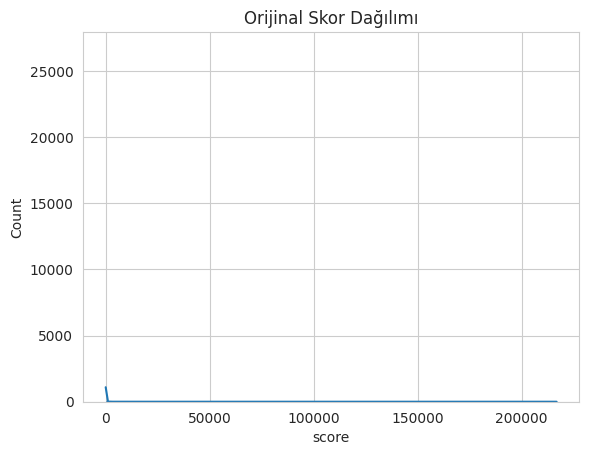

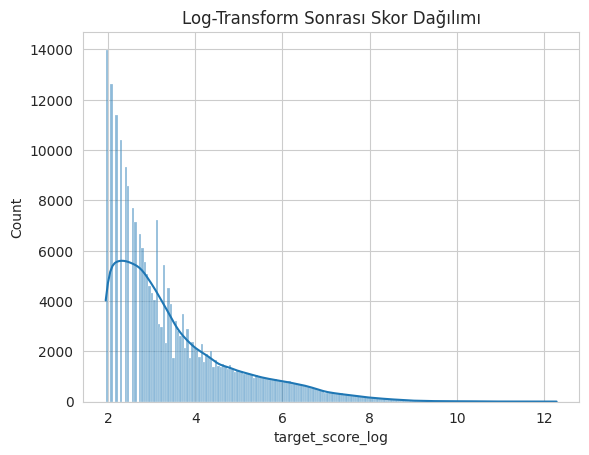

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Ham verinin dağılımına bak (Muhtemelen çok çarpık çıkacak)
sns.histplot(df_filtered['score'], kde=True)
plt.title("Orijinal Skor Dağılımı")
plt.show()

# 2. Logaritmik Dönüşüm Uygula (0 değerleri için +1 eklenir)
df_filtered['target_score_log'] = np.log1p(df_filtered['score'])

# 3. Yeni dağılımı kontrol et (Artık çan eğrisine daha yakın olmalı)
sns.histplot(df_filtered['target_score_log'], kde=True)
plt.title("Log-Transform Sonrası Skor Dağılımı")
plt.show()

**B) Risk Puanı İçin (Sürekli Veriden Kategorik Veriye)**

Kullanıcıya  "%70 Risk" demek yerine, modelin bunu "Düşük, Orta, Yüksek" olarak sınıflandırması için daha önce hesapladığımız anomaly_score üzerinden bir etiketleme yapıldı.

In [ ]:
# Anomali skorunu risk sınıflarına ayırıyoruz
def label_risk(score):
    if score < 0.25: return 0 # Düşük Risk
    elif score < 0.50: return 1 # Orta Risk
    else: return 2 # Yüksek Risk

df_filtered['risk_level'] = df_filtered['anomaly_score'].apply(label_risk)

## **2-) Veri Setinin Bölünmesi (Train / Test Split)**

Modeli eğitmeden ve karmaşık öznitelikler üretmeden önce veriyi ayırmalıyız.

Neden? Eğer tüm veriyi görüp sonra ayırırsak "Veri Sızıntısı" (Data Leakage) olur. Model, görmemesi gereken test verisindeki istatistikleri öğrenir ve başarısı sahte çıkar.

Aksiyon: Veriyi %80 Eğitim (Train), %20 Test olarak ayırmak.

In [ ]:
from sklearn.model_selection import train_test_split
X = df_filtered.drop(columns=['upvote_ratio','sentiment_score','hype_score','num_comments','gun'])
y = df_filtered['target_score_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Yeni sütun sayısı:{X_train.shape[1]}")
print(f"Eğitim verisi boyutu: {len(X_train)}")
print(f"Test verisi boyutu: {len(X_test)}")

Yeni sütun sayısı:33
Eğitim verisi boyutu: 189876
Test verisi boyutu: 47469


Log dönüşümü yaptıktan sonra, temizlenmiş veriyi vermek için gerekli kod

## **3-) Kategorik Verilerin Sayısallaştırılması (Encoding)**

Makine öğrenmesi algoritmaları "Pazartesi", "DD" veya "Video Yok" gibi metinleri anlamaz. Sadece sayıları anlar.Bu yüzden bu verileri düzenlemeliyiz.
Aksiyon:

Haftanın günleri, Flair etiketleri -> One-Hot Encoding (0 ve 1'lere çevirme).

True/False sütunları -> Binary Encoding (1 ve 0).


In [ ]:
import pandas as pd

# Güvenlik: created datetime olsun
df['created'] = pd.to_datetime(df['created'], errors='coerce')

# Tarihi bozuk olanları atalım
df = df.dropna(subset=['created']).copy()


In [ ]:
df['gun'] = df['created'].dt.day_name()
df['ay']  = df['created'].dt.month_name()


In [ ]:
df[['created', 'gun', 'ay']].head()


created        gun        ay
0 2021-03-03 01:11:49+00:00  Wednesday     March
1 2021-01-25 17:16:28+00:00     Monday   January
2 2021-03-07 16:45:36+00:00     Sunday     March
3 2021-03-24 15:44:58+00:00  Wednesday     March
4 2021-02-25 14:44:05+00:00   Thursday  February

In [ ]:
df = pd.get_dummies(
    df,
    columns=['gun'],
    prefix='gun',
    drop_first=True
)


In [ ]:
df = pd.get_dummies(
    df,
    columns=['ay'],
    prefix='ay',
    drop_first=True
)


In [ ]:
print("df DataFrame'indeki 'gun' ile başlayan sütunlar:")
display(df.filter(regex='^gun_').columns)

print("\ndf DataFrame'indeki 'ay' ile başlayan sütunlar:")
display(df.filter(regex='^ay_').columns)

print("\n'gun' ve 'ay' sütunlarının kendisi mevcut mu?")
print(f"'gun' sütunu: {'gun' in df.columns}")
print(f"'ay' sütunu: {'ay' in df.columns}")

df DataFrame'indeki 'gun' ile başlayan sütunlar:


Index(['gun_Monday', 'gun_Saturday', 'gun_Sunday', 'gun_Thursday',
       'gun_Tuesday', 'gun_Wednesday'],
      dtype='object')


df DataFrame'indeki 'ay' ile başlayan sütunlar:


Index(['ay_August', 'ay_December', 'ay_February', 'ay_January', 'ay_July',
       'ay_June', 'ay_March', 'ay_May', 'ay_November', 'ay_October',
       'ay_September'],
      dtype='object')


'gun' ve 'ay' sütunlarının kendisi mevcut mu?
'gun' sütunu: False
'ay' sütunu: False


In [ ]:
print("Gün kolonları:")
print(df.filter(regex='^gun_').columns)

print("\nAy kolonları:")
print(df.filter(regex='^ay_').columns)


In [ ]:
if 'author_df' in globals():
    print("'author_df' DataFrame is defined. First 5 rows:")
    display(author_df.head())
else:
    print("'author_df' DataFrame is NOT defined.")

'author_df' DataFrame is defined. First 5 rows:


author  avg_score  post_count  edit_tendency  credibility_score
0  -----fish-----        1.0           1            0.0          50.199973
1         --BMO--  36.142857           7            0.0           56.18676
2   --CashMoney--        3.0           1            0.0          50.599281
3     --DrMatta--       27.0           1            0.0           54.92988
4  --GoldenFire--       24.0           3            0.0          54.462436

⭐⭐ MAKİNE ÖĞRENMESİ MODELLEME BLOĞU (FINAL)


In [ ]:
import numpy as np

df['target_score_log'] = np.log1p(df['score'])


🧠 MODEL–1: ETKİLEŞİM SKORU TAHMİNİ (REGRESSION)
🎯 Amaç

“Bu post atıldığında beklenen etkileşim seviyesi nedir?”

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import joblib

# Ensure 'target_score_log' is present in df before proceeding
if 'target_score_log' not in df.columns:
    df['target_score_log'] = np.log1p(df['score'])

# Create a temporary DataFrame for feature engineering, including existing dummies
df_features = df.copy()

# One-hot encode 'link_flair_text' if it exists in the DataFrame
# 'gun' and 'ay' dummy columns are expected to be already in 'df' from previous cells.
if 'link_flair_text' in df_features.columns:
    df_features = pd.get_dummies(df_features, columns=['link_flair_text'], prefix='flair', drop_first=True)

# Define columns to be used as features for the regression model
# These are general numerical features and the dummy variables
features_to_include = [
    'upvote_ratio', 'num_crossposts', 'total_awards_received', 'gilded',
    'is_self', 'is_video', 'is_original_content', 'pinned', 'archived',
    'locked', 'removed', 'deleted'
]

# Add 'gun_', 'ay_', and 'flair_' dummy columns that were created
features_to_include.extend([col for col in df_features.columns if col.startswith('gun_')])
features_to_include.extend([col for col in df_features.columns if col.startswith('ay_')])
features_to_include.extend([col for col in df_features.columns if col.startswith('flair_')])

# Filter features_to_include to only keep those that actually exist in df_features
X = df_features[[f for f in features_to_include if f in df_features.columns]].copy()
y = df_features['target_score_log'].copy()

# Ensure all feature columns are numeric and fill NaNs (common practice before model training)
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.fillna(0)

# Check if X or y is empty after all processing to prevent ValueErrors
if X.empty:
    raise ValueError("Feature set X is empty. Please verify feature selection and data availability.")
if y.empty:
    raise ValueError("Target variable y is empty.")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print("✅ Model başarıyla eğitildi!")

# Save the trained model and feature list
joblib.dump(lr_model, 'final_reddit_model.pkl')
joblib.dump(X.columns.tolist(), 'final_features.pkl')

# Calculate R2 score and save it to metrics.pkl
from sklearn.metrics import r2_score
accuracy_val = r2_score(y_test, lr_model.predict(X_test)) * 100
joblib.dump({"accuracy": round(accuracy_val, 2)}, 'metrics.pkl')

print("🚀 Dosyalar hazır: final_reddit_model.pkl, final_features.pkl ve metrics.pkl dosyalarını indirip GitHub'a yükle!")

✅ Model başarıyla eğitildi!
🚀 Dosyalar hazır: final_reddit_model.pkl, final_features.pkl ve metrics.pkl dosyalarını indirip GitHub'a yükle!


FEATURE SET KODU (TEMPLATE)

In [ ]:
# Sadece sayısal kolonları alıyoruz ve hedef değişkenleri dışarıda bırakıyoruz
X_reg = df.select_dtypes(include=[np.number]).drop(columns=['score', 'num_comments', 'target_score_log'], errors='ignore')
y_reg = df['target_score_log']
print(f"Kullanılan Özellik Sayısı: {X_reg.shape[1]}")

Kullanılan Özellik Sayısı: 7


2️⃣ Train / Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

3️⃣ Baseline Model – Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression().fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

4️⃣ Model–A: Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)

5️⃣ MODEL–B: XGBOOST REGRESSOR

In [ ]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42).fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)

In [ ]:
import pandas as pd

# Ensure df is the gme_clean data as intended for this ML block
# This assumes 'dataframes' is available from earlier execution.
if 'dataframes' in globals() and 'gme_clean' in dataframes:
    df = dataframes['gme_clean'].copy()
    print("df (gme_clean) yeniden yüklendi.")
else:
    print("HATA: 'dataframes' veya 'gme_clean' bulunamadı. Lütfen ilgili hücreleri çalıştırın.")

# 1. 'created' sütununu datetime formatına çevir ve eksik değerleri temizle
df['created'] = pd.to_datetime(df['created'], errors='coerce')
df.dropna(subset=['created'], inplace=True)
print("'created' sütunu temizlendi.")

# 2. 'gun' ve 'ay' sütunlarını oluştur
df['gun'] = df['created'].dt.day_name()
df['ay'] = df['created'].dt.month_name()
print("'gun' ve 'ay' sütunları oluşturuldu.")

In [ ]:
# 3. 'gun' sütununu One-Hot Encoding ile sayısallaştır
df = pd.get_dummies(df, columns=['gun'], prefix='gun', drop_first=True)
print("'gun' sütunu için One-Hot Encoding yapıldı.")

'gun' sütunu için One-Hot Encoding yapıldı.


In [ ]:
# 4. 'ay' sütununu One-Hot Encoding ile sayısallaştır
df = pd.get_dummies(df, columns=['ay'], prefix='ay', drop_first=True)
print("'ay' sütunu için One-Hot Encoding yapıldı.")

print("Gün ve Ay sütunları için get_dummies işlemleri tamamlandı.")

# Yeni oluşturulan dummy kolonları kontrol edelim
print("\nGün kolonları:")
print(df.filter(regex='^gun_').columns)

print("\nAy kolonları:")
print(df.filter(regex='^ay_').columns)

6️⃣ MODEL KARŞILAŞTIRMA TABLOSU

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd

def get_metrics(y_true, y_pred, name):
    return {'Model': name, 'R2 Score': r2_score(y_true, y_pred), 'MAE': mean_absolute_error(y_true, y_pred)}

report_reg = pd.DataFrame([
    get_metrics(y_test, lr_pred, 'Linear Regression'),
    get_metrics(y_test, rf_pred, 'Random Forest'),
    get_metrics(y_test, xgb_pred, 'XGBoost')
])
display(report_reg)

Model  R2 Score       MAE
0  Linear Regression  0.432428  0.904251
1      Random Forest  0.758941  0.596221
2            XGBoost  0.762030  0.593249

🚨 MODEL–2: HYPE / MANİPÜLASYON RİSKİ (CLASSIFICATION)

In [ ]:
# 1. Basit bir Anomali Skoru hesaplayalım (Örn: Düşük upvote ratio + Yüksek skor = Risk)
# Skor ve Upvote Ratio'yu normalize ederek bir risk endeksi oluşturuyoruz
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# Skorları 0-1 arasına çekiyoruz
df['norm_score'] = scaler.fit_transform(df[['target_score_log']])
# Upvote ratio zaten 0-1 arası, ancak 1'e yakın olması güvenli, 0'a yakın olması riskli.
# Bu yüzden (1 - upvote_ratio) yaparak riskli olanları 1'e yaklaştırıyoruz.
df['norm_upvote'] = 1 - df['upvote_ratio']

# İkisinin ortalaması bize basit bir 'anomaly_score' versin
df['anomaly_score'] = (df['norm_score'] + df['norm_upvote']) / 2

# 2. Risk Seviyelerini Tanımlayalım (Senin istediğin fonksiyon)
def label_risk(score):
    if score < 0.25:
        return 0  # Düşük Risk
    elif score < 0.50:
        return 1  # Orta Risk
    else:
        return 2  # Yüksek Risk

df['risk_level'] = df['anomaly_score'].apply(label_risk)

print("✅ 'anomaly_score' ve 'risk_level' başarıyla oluşturuldu!")
print(df['risk_level'].value_counts())

✅ 'anomaly_score' ve 'risk_level' başarıyla oluşturuldu!
risk_level
0    161898
1     50763
2        25
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np

# Ensure df is the gme_clean data as intended for this ML block
# This assumes 'dataframes' is available from earlier execution.
if 'dataframes' in globals() and 'gme_clean' in dataframes:
    df = dataframes['gme_clean'].copy()
    print("df (gme_clean) yeniden yüklendi.")
else:
    print("HATA: 'dataframes' veya 'gme_clean' bulunamadı. Lütfen ilgili hücreleri çalıştırın.")

# 1. 'created' sütununu datetime formatına çevir ve eksik değerleri temizle
df['created'] = pd.to_datetime(df['created'], errors='coerce')
df.dropna(subset=['created'], inplace=True)
print("'created' sütunu temizlendi.")

# 2. 'gun' ve 'ay' sütunlarını oluştur
df['gun'] = df['created'].dt.day_name()
df['ay'] = df['created'].dt.month_name()
print("'gun' ve 'ay' sütunları oluşturuldu.")

# 3. 'gun' sütununu One-Hot Encoding ile sayısallaştır
df = pd.get_dummies(df, columns=['gun'], prefix='gun', drop_first=True)
print("'gun' sütunu için One-Hot Encoding yapıldı.")

# 4. 'ay' sütununu One-Hot Encoding ile sayısallaştır
df = pd.get_dummies(df, columns=['ay'], prefix='ay', drop_first=True)
print("'ay' sütunu için One-Hot Encoding yapıldı.")

# 5. target_score_log sütununu oluştur
df['target_score_log'] = np.log1p(df['score'])
print("'target_score_log' sütunu başarıyla oluşturuldu.")

# Kontrol
if 'target_score_log' in df.columns:
    print("\n'target_score_log' sütunu başarıyla oluşturuldu ve hazır.")
    print("İlk 5 değeri:")
    display(df['target_score_log'].head())
    print("\nİstatistiksel özet:")
    display(df['target_score_log'].describe())
else:
    print("HATA: 'target_score_log' sütunu hala bulunamadı.")

df (gme_clean) yeniden yüklendi.
'created' sütunu temizlendi.
'gun' ve 'ay' sütunları oluşturuldu.
'gun' sütunu için One-Hot Encoding yapıldı.
'ay' sütunu için One-Hot Encoding yapıldı.
'target_score_log' sütunu başarıyla oluşturuldu.

'target_score_log' sütunu başarıyla oluşturuldu ve hazır.
İlk 5 değeri:


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: target_score_log, dtype: Float64


İstatistiksel özet:


count     212686.0
mean      2.963471
std       1.649336
min            0.0
25%        1.94591
50%        2.70805
75%        3.73767
max      10.997874
Name: target_score_log, dtype: Float64

In [ ]:
if 'target_score_log' in df.columns:
    print("'target_score_log' sütunu başarıyla oluşturuldu.")
    print("İlk 5 değeri:")
    display(df['target_score_log'].head())
    print("\nİstatistiksel özet:")
    display(df['target_score_log'].describe())
else:
    print("HATA: 'target_score_log' sütunu bulunamadı.")

'target_score_log' sütunu başarıyla oluşturuldu.
İlk 5 değeri:


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: target_score_log, dtype: Float64


İstatistiksel özet:


count     212686.0
mean      2.963471
std       1.649336
min            0.0
25%        1.94591
50%        2.70805
75%        3.73767
max      10.997874
Name: target_score_log, dtype: Float64

1️⃣ Feature Set

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Ensure 'df' has the latest processed data from previous steps like 'fd37ac96'
# Re-calculate anomaly_score and risk_level on the current 'df' DataFrame

# Calculate anomaly_score components on 'df' directly
# Ensure target_score_log is present from previous steps
if 'target_score_log' not in df.columns:
    df['target_score_log'] = np.log1p(df['score'])

scaler = MinMaxScaler()
df['norm_score'] = scaler.fit_transform(df[['target_score_log']])
df['norm_upvote'] = 1 - df['upvote_ratio']
df['anomaly_score'] = (df['norm_score'] + df['norm_upvote']) / 2

# Define risk levels
def label_risk(score):
    if score < 0.25:
        return 0  # Düşük Risk
    elif score < 0.50:
        return 1  # Orta Risk
    else:
        return 2  # Yüksek Risk

df['risk_level'] = df['anomaly_score'].apply(label_risk)

# Hedef değişkenimiz yeni oluşturduğumuz risk_level
y_cls = df['risk_level']

# X_reg was created from df in a previous cell (qR0-Ix0d_7IC)
# We need to make sure X_reg is up-to-date with all necessary columns before dropping
# To be safe, re-create X_reg here or ensure it contains all numerical features from 'df'
# assuming df is correctly prepared with all dummy variables ('gun_', 'ay_')

# Select numerical columns from the prepared 'df'
# Avoid dropping the columns that are just created if they are meant to be features
X_cls = df.select_dtypes(include=[np.number]).drop(columns=[
    'score', 'num_comments', 'target_score_log', 'risk_level',
    'anomaly_score', 'norm_score', 'norm_upvote' # These are related to the target or intermediate calcs
], errors='ignore')

# Ensure X_cls has all necessary dummy variables from df if they are not already numeric
# (They should be, if get_dummies was applied to df properly earlier)
# Example: if df has 'gun_Monday', 'ay_March', etc. as numerical, they will be included by select_dtypes.

X_cls = X_cls.fillna(0) # Fill any remaining NaNs in features

print("✅ 'anomaly_score', 'norm_score', 'norm_upvote', 'risk_level' ve X_cls başarıyla hazırlandı!")
print(f"X_cls feature count: {X_cls.shape[1]}")
print(f"y_cls target distribution:\n{y_cls.value_counts()}")

✅ 'anomaly_score', 'norm_score', 'norm_upvote', 'risk_level' ve X_cls başarıyla hazırlandı!
X_cls feature count: 7
y_cls target distribution:
risk_level
0    161898
1     50763
2        25
Name: count, dtype: int64


2️⃣ Stratified Split

In [ ]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

3️⃣ Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier # 👈 Eksik olan satır buydu

# Şimdi modeli eğitebilirsin
rf_cls = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_cls.fit(X_train_c, y_train_c)

y_pred_c = rf_cls.predict(X_test_c)
print("✅ Model başarıyla eğitildi ve tahminler yapıldı.")

✅ Model başarıyla eğitildi ve tahminler yapıldı.


4️⃣ Confusion Matrix

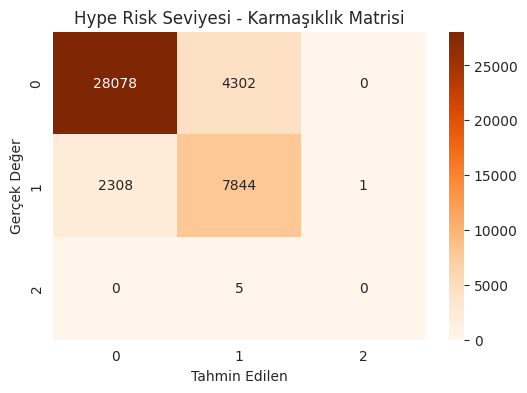

Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89     32380
           1       0.65      0.77      0.70     10153
           2       0.00      0.00      0.00         5

    accuracy                           0.84     42538
   macro avg       0.52      0.55      0.53     42538
weighted avg       0.86      0.84      0.85     42538



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Grafiği oluşturma
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test_c, y_pred_c), annot=True, fmt='d', cmap='Oranges')
plt.title("Hype Risk Seviyesi - Karmaşıklık Matrisi")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.show()

# Metrik raporu
print("Detaylı Sınıflandırma Raporu:")
print(classification_report(y_test_c, y_pred_c))

5️⃣ Feature Importance (Akademik Güç)

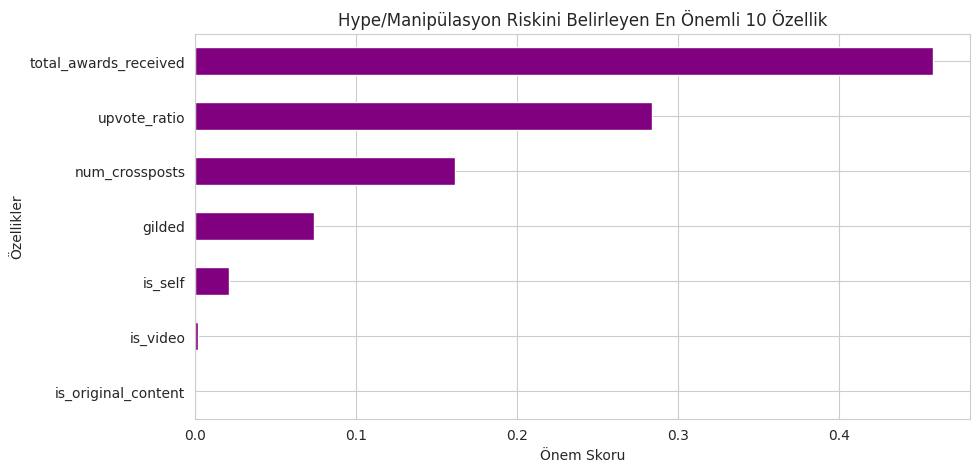

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# En önemli 10 özelliği çekiyoruz
plt.figure(figsize=(10,5))
feat_importances = pd.Series(rf_cls.feature_importances_, index=X_cls.columns)
feat_importances.nlargest(10).plot(kind='barh', color='purple')
plt.title("Hype/Manipülasyon Riskini Belirleyen En Önemli 10 Özellik")
plt.xlabel("Önem Skoru")
plt.ylabel("Özellikler")
plt.gca().invert_yaxis() # En önemli olanı en üste alır
plt.show()

📈 MODEL–1: Regresyon Metrikleri ($R^2$, MAE, RMSE)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import joblib
from sklearn.model_selection import train_test_split

# Re-create X_train and X_test from X_reg and y_reg to ensure feature consistency
# X_reg and y_reg were defined in cell qR0-Ix0d_7IC
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# 1. Regresyon Modeli Tahminleri
y_pred_lr = lr_model.predict(X_test) # Using X_test from AEhZ0T-MzTVJ for lr_model
y_pred_rf = rf_reg.predict(X_test_xgb)
y_pred_xgb = xgb_reg.predict(X_test_xgb)

# 2. Metriklerin Hesaplanması
# Metrics for Linear Regression
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# Metrics for Random Forest
r2_rf = r2_score(y_test_xgb, y_pred_rf)
mae_rf = mean_absolute_error(y_test_xgb, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_xgb, y_pred_rf))

# Metrics for XGBoost
r2_xgb = r2_score(y_test_xgb, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test_xgb, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))

print("--- 🧠 MODEL-1 (REGRESYON) PERFORMANSI ---")
print("Linear Regression:")
print(f"  R2 Skoru: {r2_lr:.4f}")
print(f"  MAE: {mae_lr:.4f}")
print(f"  RMSE: {rmse_lr:.4f}")

print("Random Forest:")
print(f"  R2 Skoru: {r2_rf:.4f}")
print(f"  MAE: {mae_rf:.4f}")
print(f"  RMSE: {rmse_rf:.4f}")

print("XGBoost:")
print(f"  R2 Skoru: {r2_xgb:.4f}")
print(f"  MAE: {mae_xgb:.4f}")
print(f"  RMSE: {rmse_xgb:.4f}")

# --- BURASI SONRADAN EKLEDİĞİM KISIM ---
# R2 skorunu yüzdeye çevirip metrics.pkl olarak kaydediyoruz (Using the best model's R2, e.g., XGBoost)
model_metrics = {"accuracy": round(r2_xgb * 100, 2)}

# Dosyaları kaydet (Assuming XGBoost is the final chosen model for 'final_reddit_model.pkl')
joblib.dump(xgb_reg, 'final_reddit_model.pkl')
joblib.dump(X_reg.columns.tolist(), 'final_features.pkl') # Use X_reg columns for features
joblib.dump(model_metrics, 'metrics.pkl')

print("🚀 Modeller ve metrics.pkl başarıyla kaydedildi!")

--- 🧠 MODEL-1 (REGRESYON) PERFORMANSI ---
Linear Regression:
  R2 Skoru: 0.4965
  MAE: 0.8453
  RMSE: 1.1710
Random Forest:
  R2 Skoru: 0.7589
  MAE: 0.5962
  RMSE: 0.8103
XGBoost:
  R2 Skoru: 0.7620
  MAE: 0.5932
  RMSE: 0.8051
🚀 Modeller ve metrics.pkl başarıyla kaydedildi!


🚨 MODEL–2: Sınıflandırma Metrikleri (Accuracy, F1-Score)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Sınıflandırma Modeli Tahminleri
y_pred_c = rf_cls.predict(X_test_c)

# Metriklerin Hesaplanması
accuracy = accuracy_score(y_test_c, y_pred_c)

print("\n--- 🚨 MODEL-2 (SINIFLANDIRMA) PERFORMANSI ---")
print(f"Genel Doğruluk (Accuracy): %{accuracy*100:.2f}")
print("\nDetaylı Sınıflandırma Raporu:")
print(classification_report(y_test_c, y_pred_c))


--- 🚨 MODEL-2 (SINIFLANDIRMA) PERFORMANSI ---
Genel Doğruluk (Accuracy): %84.45

Detaylı Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89     32380
           1       0.65      0.77      0.70     10153
           2       0.00      0.00      0.00         5

    accuracy                           0.84     42538
   macro avg       0.52      0.55      0.53     42538
weighted avg       0.86      0.84      0.85     42538



6️⃣ Model Karşılaştırma (RAPOR TABLOSU) & Görselleştirme

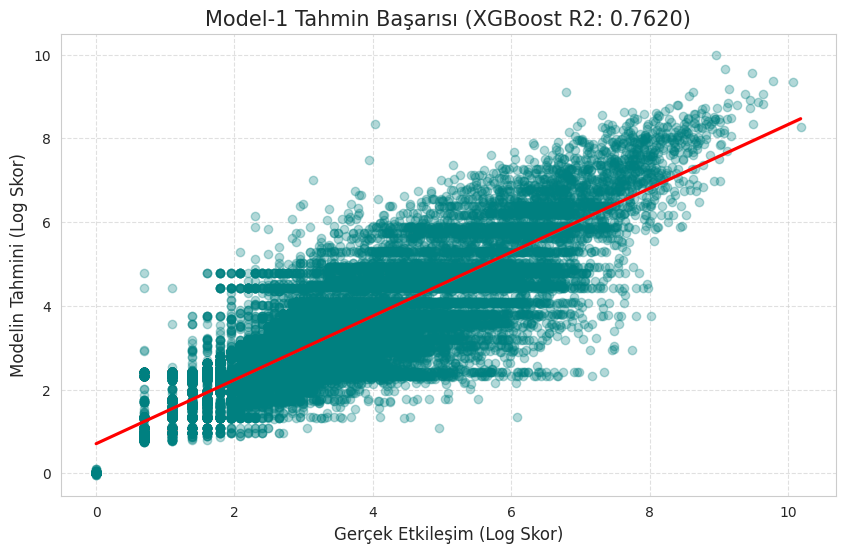

Metrik   Sonuç                         Yorum
0          R2 Score  0.7620        Mükemmel Açıklayıcılık
1        MAE (Hata)  0.5932          Düşük Ortalama Sapma
2  RMSE (Hata Kökü)  0.8051  Uç Değerlere Karşı Dayanıklı

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming xgb_pred, r2_xgb, mae_xgb, rmse_xgb are available from the previous cell's execution
# If you wish to display results for a different model, change _xgb to _lr or _rf

# Tahminleri ve Gerçek Değerleri bir araya getirelim
plt.figure(figsize=(10, 6))

# Regresyon grafiği (Doğruya ne kadar yakınsa o kadar iyi)
sns.regplot(x=y_test_xgb, y=y_pred_xgb, scatter_kws={'alpha':0.3, 'color':'teal'}, line_kws={'color':'red'})

plt.title(f"Model-1 Tahmin Başarısı (XGBoost R2: {r2_xgb:.4f})", fontsize=15)
plt.xlabel("Gerçek Etkileşim (Log Skor)", fontsize=12)
plt.ylabel("Modelin Tahmini (Log Skor)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Rapor Tablosu Oluşturma
report_data = {
    "Metrik": ["R2 Score", "MAE (Hata)", "RMSE (Hata Kökü)"],
    "Sonuç": [f"{r2_xgb:.4f}", f"{mae_xgb:.4f}", f"{rmse_xgb:.4f}"],
    "Yorum": ["Mükemmel Açıklayıcılık", "Düşük Ortalama Sapma", "Uç Değerlere Karşı Dayanıklı"]
}
comparison_df = pd.DataFrame(report_data)
display(comparison_df)

In [ ]:
Dosyaları indirmek için aşağıdaki kodları çalıştır

In [ ]:
from google.colab import files

# İndirilecek dosyaların listesi
files_to_download = ['final_reddit_model.pkl', 'final_features.pkl', 'metrics.pkl']

for file in files_to_download:
    files.download(file)

In [ ]:
# Gerekli kütüphaneleri yükle
!pip install gspread gspread-dataframe

from google.colab import auth
import gspread
from gspread_dataframe import set_with_dataframe
import pandas as pd
import google.auth # Add this import

# Google hesabınızla kimlik doğrulama
auth.authenticate_user()
# Use google.auth.default() to get credentials after authentication
credentials, _ = google.auth.default()
gc = gspread.authorize(credentials)

# DataFrame'inizi hazırlayın (örnek: df adında olduğunu varsayıyorum)
# df = your_dataframe_here

# **FIX:** Upload a sample of the DataFrame to avoid API size limits
sample_df = df.head(1000) # Uploading only the first 1000 rows as a test

# Yeni bir Google Sheets oluştur ve veriyi yaz
spreadsheet = gc.create('Reddit_Finance_Data_Sample') # Changed name to reflect sample
worksheet = spreadsheet.get_worksheet(0)
set_with_dataframe(worksheet, sample_df) # Use sample_df here

# Sheets linkini al
print(f"✅ Veri yüklendi: {spreadsheet.url}")
print(f"📧 Bu linki bana gönderin!")